In [2]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pandas as pd
import argparse
import os
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.utils.data as data

import torch.nn as nn
import torch.nn.functional as F
import torch

dev = qml.device('cirq.simulator', wires=2)
dev = qml.device('default.qubit', wires=2)

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=2, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.001, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=10, help="interval betwen image samples")
config = parser.parse_known_args()[0]
print(config)

Namespace(b1=0.5, b2=0.999, batch_size=2, channels=1, img_size=28, latent_dim=100, lr=0.001, n_cpu=8, n_epochs=20, sample_interval=10)


In [4]:
# Loss function
adversarial_loss = torch.nn.BCELoss(size_average=False)
cuda = True if torch.cuda.is_available() else False

cuda = False
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
gen_weights = torch.randn( 3, 1, requires_grad=True)

/home/junde/anaconda3/envs/kongsr/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [5]:
@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # Sample noise as generator input
    z = random.uniform(-1, 1)

    qml.RY(np.arcsin(z), wires=0)
    qml.RY(np.arcsin(z), wires=1)
    qml.RZ(np.arccos(z), wires=0)
    qml.RZ(np.arccos(z), wires=1)
    qml.RY(w[0], wires=0)
    qml.RY(w[1], wires=1)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.CNOT(wires=[0, 1])
    qml.RZ(w[2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    return qml.expval(qml.PauliZ(0))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, sample):
        sample_flat = sample.view(sample.size(0), -1)
        validity = self.model(sample_flat)

        return validity
    
discriminator = Discriminator()

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [6]:
class BimodalDataset(data.Dataset):
    """Bimodal distribution dataset."""
    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.df = pd.read_csv(csv_file, header=None)
    def __len__(self):
        return len(self.df.to_numpy()[0])
    def __getitem__(self, idx):
        item = self.df.to_numpy()[0][idx]
        return item 
 
filename = 'data_bimodal.csv'
dataset = BimodalDataset(filename)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, shuffle=False)

In [6]:
def generator_cost(gen_weights):
    gen_samples = Tensor([])
    sample1 = gen_circuit(gen_weights)
    sample2 = gen_circuit(gen_weights)
    gen_samples = torch.stack((sample1, sample2))
    loss = adversarial_loss(discriminator(torch.unsqueeze(gen_samples.float(), 1)), valid)
    return loss.mean()

In [7]:
# Adversarial ground truths
valid = Variable(Tensor(config.batch_size).fill_(1.0), requires_grad=False)
fake = Variable(Tensor(config.batch_size).fill_(0.0), requires_grad=False)
gen_weights = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
# optimizer_G = torch.optim.Adam([gen_weights], lr = config.lr)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config.lr)
optimizer_G = torch.optim.SGD([gen_weights], lr=config.lr, momentum=0.9)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=config.lr, momentum=0.9)

for epoch in range(config.n_epochs):
    for i, samples in enumerate(dataloader):
        # Configure input
        real_samples = Variable(samples.type(Tensor))
        
        # -----------------
        #  Train Generator
        # -----------------
        
        optimizer_G.zero_grad()
        
        # Generate a batch of samples
        gen_samples = Tensor([])
        sample1 = gen_circuit(gen_weights)
        sample2 = gen_circuit(gen_weights)
        gen_samples = torch.stack((sample1, sample2))
        loss = adversarial_loss(discriminator(torch.unsqueeze(gen_samples.float(), 1)), valid)
        g_loss = loss.mean()

        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
#         if (i%2 == 1):
        k = 5
        for j in range(k):
            gen_samples = Tensor([])
            sample1 = gen_circuit(gen_weights)
            sample2 = gen_circuit(gen_weights)
            gen_samples = torch.stack((sample1, sample2))

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_samples), valid)
            fake_loss = adversarial_loss(discriminator(gen_samples.float()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()
        
        if i % config.sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, config.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
            print(gen_weights.detach())

/home/junde/anaconda3/envs/kongsr/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[Epoch 0/20] [Batch 0/5000] [D loss: 1.442871] [G loss: 1.006900]
tensor([1.0002, 2.0000, 3.0000])
[Epoch 0/20] [Batch 10/5000] [D loss: 1.224726] [G loss: 1.314700]
tensor([1.0134, 1.9999, 2.9984])
[Epoch 0/20] [Batch 20/5000] [D loss: 1.404426] [G loss: 1.863858]
tensor([1.0600, 1.9996, 2.9965])
[Epoch 0/20] [Batch 30/5000] [D loss: 1.195703] [G loss: 1.746478]
tensor([1.1415, 1.9997, 2.9971])
[Epoch 0/20] [Batch 40/5000] [D loss: 1.200186] [G loss: 1.271467]
tensor([1.2472, 1.9994, 2.9954])
[Epoch 0/20] [Batch 50/5000] [D loss: 1.433402] [G loss: 1.391158]
tensor([1.3678, 1.9991, 2.9937])
[Epoch 0/20] [Batch 60/5000] [D loss: 1.436283] [G loss: 1.410860]
tensor([1.4809, 1.9990, 2.9960])
[Epoch 0/20] [Batch 70/5000] [D loss: 1.378525] [G loss: 1.313053]
tensor([1.5795, 1.9994, 3.0008])
[Epoch 0/20] [Batch 80/5000] [D loss: 1.389446] [G loss: 1.162123]
tensor([1.6628, 2.0001, 3.0076])
[Epoch 0/20] [Batch 90/5000] [D loss: 1.396842] [G loss: 1.498965]
tensor([1.7247, 2.0007, 3.0130])
[

[Epoch 0/20] [Batch 820/5000] [D loss: 1.167494] [G loss: 1.657775]
tensor([1.5434, 1.9979, 2.9563])
[Epoch 0/20] [Batch 830/5000] [D loss: 1.367614] [G loss: 1.417175]
tensor([1.5029, 1.9989, 2.9607])
[Epoch 0/20] [Batch 840/5000] [D loss: 1.177422] [G loss: 1.288847]
tensor([1.4778, 1.9999, 2.9630])
[Epoch 0/20] [Batch 850/5000] [D loss: 1.332854] [G loss: 1.341495]
tensor([1.4618, 2.0000, 2.9630])
[Epoch 0/20] [Batch 860/5000] [D loss: 1.288961] [G loss: 1.920588]
tensor([1.4389, 2.0001, 2.9605])
[Epoch 0/20] [Batch 870/5000] [D loss: 1.192291] [G loss: 2.184062]
tensor([1.3745, 1.9984, 2.9525])
[Epoch 0/20] [Batch 880/5000] [D loss: 1.327737] [G loss: 1.331827]
tensor([1.3124, 1.9972, 2.9436])
[Epoch 0/20] [Batch 890/5000] [D loss: 1.273775] [G loss: 1.182584]
tensor([1.3089, 1.9984, 2.9470])
[Epoch 0/20] [Batch 900/5000] [D loss: 1.148244] [G loss: 1.217755]
tensor([1.3216, 2.0001, 2.9561])
[Epoch 0/20] [Batch 910/5000] [D loss: 1.227837] [G loss: 1.366048]
tensor([1.3468, 2.0010,

[Epoch 0/20] [Batch 1630/5000] [D loss: 1.495988] [G loss: 1.483806]
tensor([1.4680, 2.0188, 3.1742])
[Epoch 0/20] [Batch 1640/5000] [D loss: 1.247705] [G loss: 1.181092]
tensor([1.4560, 2.0195, 3.1599])
[Epoch 0/20] [Batch 1650/5000] [D loss: 1.537607] [G loss: 1.022121]
tensor([1.3790, 2.0197, 3.1521])
[Epoch 0/20] [Batch 1660/5000] [D loss: 1.311538] [G loss: 1.708230]
tensor([1.3944, 2.0199, 3.1413])
[Epoch 0/20] [Batch 1670/5000] [D loss: 1.253131] [G loss: 2.642910]
tensor([1.4229, 2.0199, 3.1183])
[Epoch 0/20] [Batch 1680/5000] [D loss: 1.324666] [G loss: 2.440596]
tensor([1.4294, 2.0199, 3.1092])
[Epoch 0/20] [Batch 1690/5000] [D loss: 1.019945] [G loss: 1.577542]
tensor([1.4365, 2.0193, 3.0909])
[Epoch 0/20] [Batch 1700/5000] [D loss: 1.490490] [G loss: 1.934944]
tensor([1.4512, 2.0189, 3.0725])
[Epoch 0/20] [Batch 1710/5000] [D loss: 1.280559] [G loss: 1.521534]
tensor([1.4819, 2.0197, 3.0725])
[Epoch 0/20] [Batch 1720/5000] [D loss: 1.333278] [G loss: 2.650651]
tensor([1.491

[Epoch 0/20] [Batch 2440/5000] [D loss: 1.153311] [G loss: 2.385479]
tensor([1.5422, 2.0397, 3.2652])
[Epoch 0/20] [Batch 2450/5000] [D loss: 1.286971] [G loss: 3.748251]
tensor([1.4522, 2.0384, 3.3007])
[Epoch 0/20] [Batch 2460/5000] [D loss: 1.317514] [G loss: 1.724606]
tensor([1.4980, 2.0438, 3.3197])
[Epoch 0/20] [Batch 2470/5000] [D loss: 1.208055] [G loss: 3.301196]
tensor([1.5914, 2.0461, 3.3246])
[Epoch 0/20] [Batch 2480/5000] [D loss: 1.406202] [G loss: 1.780833]
tensor([1.4898, 2.0477, 3.3287])
[Epoch 0/20] [Batch 2490/5000] [D loss: 1.235718] [G loss: 1.409477]
tensor([1.3871, 2.0449, 3.3448])
[Epoch 0/20] [Batch 2500/5000] [D loss: 1.393954] [G loss: 1.797575]
tensor([1.3740, 2.0449, 3.3259])
[Epoch 0/20] [Batch 2510/5000] [D loss: 1.107533] [G loss: 2.290196]
tensor([1.3926, 2.0457, 3.3188])
[Epoch 0/20] [Batch 2520/5000] [D loss: 1.423691] [G loss: 1.307666]
tensor([1.5208, 2.0445, 3.3115])
[Epoch 0/20] [Batch 2530/5000] [D loss: 1.329086] [G loss: 2.050140]
tensor([1.421

[Epoch 0/20] [Batch 3250/5000] [D loss: 1.568339] [G loss: 1.100379]
tensor([1.6832, 1.9483, 3.5558])
[Epoch 0/20] [Batch 3260/5000] [D loss: 1.220251] [G loss: 1.187896]
tensor([1.5967, 1.9393, 3.5769])
[Epoch 0/20] [Batch 3270/5000] [D loss: 1.483098] [G loss: 1.961607]
tensor([1.3407, 1.9092, 3.6694])
[Epoch 0/20] [Batch 3280/5000] [D loss: 0.779347] [G loss: 2.263784]
tensor([1.3540, 1.8858, 3.7211])
[Epoch 0/20] [Batch 3290/5000] [D loss: 0.798614] [G loss: 1.039204]
tensor([1.5074, 1.8802, 3.7131])
[Epoch 0/20] [Batch 3300/5000] [D loss: 1.325276] [G loss: 2.407304]
tensor([1.5851, 1.8724, 3.6938])
[Epoch 0/20] [Batch 3310/5000] [D loss: 0.645174] [G loss: 1.159895]
tensor([1.4569, 1.8636, 3.7395])
[Epoch 0/20] [Batch 3320/5000] [D loss: 1.484614] [G loss: 2.189012]
tensor([1.3264, 1.8893, 3.7401])
[Epoch 0/20] [Batch 3330/5000] [D loss: 1.060890] [G loss: 3.018539]
tensor([1.4087, 1.9104, 3.6770])
[Epoch 0/20] [Batch 3340/5000] [D loss: 1.364717] [G loss: 1.670320]
tensor([1.478

[Epoch 0/20] [Batch 4060/5000] [D loss: 1.232580] [G loss: 1.985044]
tensor([1.6445, 1.5867, 4.2383])
[Epoch 0/20] [Batch 4070/5000] [D loss: 1.018536] [G loss: 1.800069]
tensor([1.6676, 1.5590, 4.3182])
[Epoch 0/20] [Batch 4080/5000] [D loss: 1.484321] [G loss: 2.220973]
tensor([1.7883, 1.5644, 4.2768])
[Epoch 0/20] [Batch 4090/5000] [D loss: 1.354306] [G loss: 2.364930]
tensor([1.7976, 1.6108, 4.2441])
[Epoch 0/20] [Batch 4100/5000] [D loss: 1.134780] [G loss: 2.350789]
tensor([1.6835, 1.6525, 4.2892])
[Epoch 0/20] [Batch 4110/5000] [D loss: 1.108919] [G loss: 2.798942]
tensor([1.6504, 1.6784, 4.3108])
[Epoch 0/20] [Batch 4120/5000] [D loss: 1.239799] [G loss: 2.399626]
tensor([1.7030, 1.6825, 4.2275])
[Epoch 0/20] [Batch 4130/5000] [D loss: 1.069255] [G loss: 2.202119]
tensor([1.6270, 1.6681, 4.2104])
[Epoch 0/20] [Batch 4140/5000] [D loss: 1.359601] [G loss: 1.447065]
tensor([1.6000, 1.6436, 4.2613])
[Epoch 0/20] [Batch 4150/5000] [D loss: 1.529480] [G loss: 1.751352]
tensor([1.655

[Epoch 0/20] [Batch 4870/5000] [D loss: 1.333898] [G loss: 1.062528]
tensor([1.5378, 1.1752, 4.2463])
[Epoch 0/20] [Batch 4880/5000] [D loss: 0.587317] [G loss: 0.812739]
tensor([1.6523, 1.1526, 4.1732])
[Epoch 0/20] [Batch 4890/5000] [D loss: 0.978025] [G loss: 3.900874]
tensor([1.7548, 1.1608, 4.1371])
[Epoch 0/20] [Batch 4900/5000] [D loss: 0.783474] [G loss: 4.183145]
tensor([1.7829, 1.1408, 4.1068])
[Epoch 0/20] [Batch 4910/5000] [D loss: 1.165888] [G loss: 2.999720]
tensor([1.7400, 1.1313, 4.2302])
[Epoch 0/20] [Batch 4920/5000] [D loss: 1.019377] [G loss: 3.564076]
tensor([1.6929, 1.1950, 4.1192])
[Epoch 0/20] [Batch 4930/5000] [D loss: 1.179816] [G loss: 1.858555]
tensor([1.6330, 1.2327, 3.9504])
[Epoch 0/20] [Batch 4940/5000] [D loss: 1.162576] [G loss: 1.746988]
tensor([1.6142, 1.2557, 3.8124])
[Epoch 0/20] [Batch 4950/5000] [D loss: 1.109592] [G loss: 2.643423]
tensor([1.4043, 1.2786, 3.8481])
[Epoch 0/20] [Batch 4960/5000] [D loss: 1.570506] [G loss: 1.945582]
tensor([1.584

[Epoch 1/20] [Batch 690/5000] [D loss: 0.579173] [G loss: 3.670239]
tensor([1.9808, 0.8762, 4.4253])
[Epoch 1/20] [Batch 700/5000] [D loss: 0.495956] [G loss: 1.137051]
tensor([1.9699, 0.9665, 4.2451])
[Epoch 1/20] [Batch 710/5000] [D loss: 1.053849] [G loss: 5.213604]
tensor([1.8590, 1.0325, 4.3267])
[Epoch 1/20] [Batch 720/5000] [D loss: 0.613064] [G loss: 3.560925]
tensor([1.7863, 1.0980, 4.3987])
[Epoch 1/20] [Batch 730/5000] [D loss: 1.586981] [G loss: 1.589905]
tensor([1.8723, 1.1395, 4.1872])
[Epoch 1/20] [Batch 740/5000] [D loss: 1.754529] [G loss: 5.188754]
tensor([1.9029, 1.1530, 4.0427])
[Epoch 1/20] [Batch 750/5000] [D loss: 1.070194] [G loss: 4.819389]
tensor([1.7703, 1.1317, 4.2708])
[Epoch 1/20] [Batch 760/5000] [D loss: 1.206285] [G loss: 6.520183]
tensor([1.6462, 1.1130, 4.2839])
[Epoch 1/20] [Batch 770/5000] [D loss: 1.037696] [G loss: 3.918814]
tensor([1.5651, 1.1233, 4.0609])
[Epoch 1/20] [Batch 780/5000] [D loss: 1.186033] [G loss: 3.315798]
tensor([1.5978, 1.1192,

[Epoch 1/20] [Batch 1500/5000] [D loss: 1.617696] [G loss: 8.117559]
tensor([1.4584, 1.1475, 3.9396])
[Epoch 1/20] [Batch 1510/5000] [D loss: 0.985746] [G loss: 5.821350]
tensor([1.7315, 1.1701, 3.7276])
[Epoch 1/20] [Batch 1520/5000] [D loss: 1.416552] [G loss: 1.084974]
tensor([1.5223, 1.1884, 3.6985])
[Epoch 1/20] [Batch 1530/5000] [D loss: 0.770825] [G loss: 4.856771]
tensor([1.4226, 1.1742, 3.7653])
[Epoch 1/20] [Batch 1540/5000] [D loss: 1.551200] [G loss: 6.242614]
tensor([1.5765, 1.1468, 3.8541])
[Epoch 1/20] [Batch 1550/5000] [D loss: 1.465522] [G loss: 4.026704]
tensor([1.5677, 1.1033, 3.9628])
[Epoch 1/20] [Batch 1560/5000] [D loss: 1.609788] [G loss: 2.395957]
tensor([1.6030, 1.0703, 3.9851])
[Epoch 1/20] [Batch 1570/5000] [D loss: 0.973509] [G loss: 7.717227]
tensor([1.7989, 1.0296, 3.9404])
[Epoch 1/20] [Batch 1580/5000] [D loss: 1.415991] [G loss: 4.922128]
tensor([1.5955, 1.0190, 4.0672])
[Epoch 1/20] [Batch 1590/5000] [D loss: 1.356787] [G loss: 4.800645]
tensor([1.510

[Epoch 1/20] [Batch 2300/5000] [D loss: 0.884640] [G loss: 1.236927]
tensor([ 1.6472, -0.2908,  4.1026])
[Epoch 1/20] [Batch 2310/5000] [D loss: 1.532543] [G loss: 1.612897]
tensor([ 1.6583, -0.3185,  4.0870])
[Epoch 1/20] [Batch 2320/5000] [D loss: 1.595671] [G loss: 1.327520]
tensor([ 1.6797, -0.3799,  4.0812])
[Epoch 1/20] [Batch 2330/5000] [D loss: 1.350776] [G loss: 1.203803]
tensor([ 1.6840, -0.4512,  4.0666])
[Epoch 1/20] [Batch 2340/5000] [D loss: 1.430967] [G loss: 1.269408]
tensor([ 1.6232, -0.4419,  4.0509])
[Epoch 1/20] [Batch 2350/5000] [D loss: 1.279016] [G loss: 1.309972]
tensor([ 1.4959, -0.4396,  4.0613])
[Epoch 1/20] [Batch 2360/5000] [D loss: 1.288733] [G loss: 3.569885]
tensor([ 1.3270, -0.4030,  4.0065])
[Epoch 1/20] [Batch 2370/5000] [D loss: 0.984844] [G loss: 2.149613]
tensor([ 1.3677, -0.4362,  3.8078])
[Epoch 1/20] [Batch 2380/5000] [D loss: 1.313953] [G loss: 1.535328]
tensor([ 1.5203, -0.5086,  3.7309])
[Epoch 1/20] [Batch 2390/5000] [D loss: 1.555906] [G lo

[Epoch 1/20] [Batch 3090/5000] [D loss: 1.300290] [G loss: 1.311836]
tensor([ 1.9779, -0.9885,  4.3490])
[Epoch 1/20] [Batch 3100/5000] [D loss: 1.528292] [G loss: 1.506014]
tensor([ 1.9506, -0.9904,  4.4117])
[Epoch 1/20] [Batch 3110/5000] [D loss: 1.390946] [G loss: 1.272488]
tensor([ 1.9807, -0.9883,  4.3522])
[Epoch 1/20] [Batch 3120/5000] [D loss: 1.300095] [G loss: 1.500601]
tensor([ 2.0008, -0.9664,  4.2258])
[Epoch 1/20] [Batch 3130/5000] [D loss: 1.452779] [G loss: 1.673964]
tensor([ 1.9485, -0.9663,  4.2510])
[Epoch 1/20] [Batch 3140/5000] [D loss: 1.317993] [G loss: 1.289479]
tensor([ 1.8854, -0.9657,  4.3457])
[Epoch 1/20] [Batch 3150/5000] [D loss: 1.473694] [G loss: 1.177417]
tensor([ 1.8766, -0.9414,  4.3530])
[Epoch 1/20] [Batch 3160/5000] [D loss: 1.355842] [G loss: 1.420953]
tensor([ 1.9445, -0.8970,  4.2589])
[Epoch 1/20] [Batch 3170/5000] [D loss: 1.412282] [G loss: 1.355391]
tensor([ 1.9683, -0.8771,  4.2268])
[Epoch 1/20] [Batch 3180/5000] [D loss: 1.337517] [G lo

[Epoch 1/20] [Batch 3880/5000] [D loss: 1.425558] [G loss: 1.416932]
tensor([ 1.8719, -0.8422,  4.3248])
[Epoch 1/20] [Batch 3890/5000] [D loss: 1.418847] [G loss: 1.266055]
tensor([ 1.8923, -0.8449,  4.2786])
[Epoch 1/20] [Batch 3900/5000] [D loss: 1.381362] [G loss: 1.393351]
tensor([ 1.9098, -0.8480,  4.2437])
[Epoch 1/20] [Batch 3910/5000] [D loss: 1.272652] [G loss: 1.365921]
tensor([ 1.9170, -0.8499,  4.2302])
[Epoch 1/20] [Batch 3920/5000] [D loss: 1.368969] [G loss: 1.409822]
tensor([ 1.9135, -0.8524,  4.2369])
[Epoch 1/20] [Batch 3930/5000] [D loss: 1.324719] [G loss: 1.319938]
tensor([ 1.9013, -0.8539,  4.2597])
[Epoch 1/20] [Batch 3940/5000] [D loss: 1.439778] [G loss: 1.384799]
tensor([ 1.8473, -0.8579,  4.3211])
[Epoch 1/20] [Batch 3950/5000] [D loss: 1.329076] [G loss: 1.148945]
tensor([ 1.8106, -0.8574,  4.3678])
[Epoch 1/20] [Batch 3960/5000] [D loss: 1.358896] [G loss: 1.346167]
tensor([ 1.7871, -0.8530,  4.4016])
[Epoch 1/20] [Batch 3970/5000] [D loss: 1.344726] [G lo

[Epoch 1/20] [Batch 4670/5000] [D loss: 1.421205] [G loss: 1.370559]
tensor([ 1.7513, -0.7030,  4.2457])
[Epoch 1/20] [Batch 4680/5000] [D loss: 1.374317] [G loss: 1.388250]
tensor([ 1.7156, -0.7130,  4.2762])
[Epoch 1/20] [Batch 4690/5000] [D loss: 1.412987] [G loss: 1.364651]
tensor([ 1.7083, -0.7165,  4.2807])
[Epoch 1/20] [Batch 4700/5000] [D loss: 1.362876] [G loss: 1.379333]
tensor([ 1.7195, -0.7231,  4.2766])
[Epoch 1/20] [Batch 4710/5000] [D loss: 1.412682] [G loss: 1.292618]
tensor([ 1.7457, -0.7243,  4.2521])
[Epoch 1/20] [Batch 4720/5000] [D loss: 1.457022] [G loss: 2.230564]
tensor([ 1.7685, -0.7259,  4.2105])
[Epoch 1/20] [Batch 4730/5000] [D loss: 1.331694] [G loss: 1.492441]
tensor([ 1.7332, -0.7181,  4.3020])
[Epoch 1/20] [Batch 4740/5000] [D loss: 1.318515] [G loss: 1.422706]
tensor([ 1.7379, -0.7186,  4.3091])
[Epoch 1/20] [Batch 4750/5000] [D loss: 1.758817] [G loss: 1.176804]
tensor([ 1.7626, -0.7170,  4.2634])
[Epoch 1/20] [Batch 4760/5000] [D loss: 1.252546] [G lo

[Epoch 2/20] [Batch 460/5000] [D loss: 1.378114] [G loss: 1.383960]
tensor([ 1.8323, -0.6364,  4.3251])
[Epoch 2/20] [Batch 470/5000] [D loss: 1.384201] [G loss: 1.374174]
tensor([ 1.8438, -0.6350,  4.3107])
[Epoch 2/20] [Batch 480/5000] [D loss: 1.375027] [G loss: 1.358558]
tensor([ 1.8494, -0.6340,  4.3023])
[Epoch 2/20] [Batch 490/5000] [D loss: 1.370953] [G loss: 1.342648]
tensor([ 1.8570, -0.6327,  4.2886])
[Epoch 2/20] [Batch 500/5000] [D loss: 1.389058] [G loss: 1.375733]
tensor([ 1.8649, -0.6320,  4.2760])
[Epoch 2/20] [Batch 510/5000] [D loss: 1.385754] [G loss: 1.299439]
tensor([ 1.8644, -0.6320,  4.2771])
[Epoch 2/20] [Batch 520/5000] [D loss: 1.383124] [G loss: 1.345013]
tensor([ 1.8597, -0.6322,  4.2847])
[Epoch 2/20] [Batch 530/5000] [D loss: 1.382973] [G loss: 1.365451]
tensor([ 1.8565, -0.6266,  4.3487])
[Epoch 2/20] [Batch 540/5000] [D loss: 1.392170] [G loss: 1.393735]
tensor([ 1.8559, -0.6213,  4.4047])
[Epoch 2/20] [Batch 550/5000] [D loss: 1.352691] [G loss: 1.4396

[Epoch 2/20] [Batch 1250/5000] [D loss: 1.411328] [G loss: 1.382770]
tensor([ 1.9171, -0.4952,  4.4149])
[Epoch 2/20] [Batch 1260/5000] [D loss: 1.320228] [G loss: 1.323791]
tensor([ 1.9200, -0.4955,  4.4080])
[Epoch 2/20] [Batch 1270/5000] [D loss: 1.279676] [G loss: 1.447404]
tensor([ 1.9281, -0.4984,  4.3876])
[Epoch 2/20] [Batch 1280/5000] [D loss: 1.491857] [G loss: 1.296425]
tensor([ 1.9444, -0.5028,  4.3430])
[Epoch 2/20] [Batch 1290/5000] [D loss: 1.267821] [G loss: 1.322872]
tensor([ 1.9698, -0.5112,  4.2803])
[Epoch 2/20] [Batch 1300/5000] [D loss: 1.438272] [G loss: 1.290992]
tensor([ 1.9901, -0.4922,  4.2747])
[Epoch 2/20] [Batch 1310/5000] [D loss: 1.395136] [G loss: 1.392227]
tensor([ 1.9669, -0.4820,  4.3662])
[Epoch 2/20] [Batch 1320/5000] [D loss: 1.361523] [G loss: 1.358784]
tensor([ 1.9302, -0.4811,  4.4514])
[Epoch 2/20] [Batch 1330/5000] [D loss: 1.399261] [G loss: 1.367109]
tensor([ 1.9162, -0.4817,  4.4856])
[Epoch 2/20] [Batch 1340/5000] [D loss: 1.409150] [G lo

[Epoch 2/20] [Batch 2040/5000] [D loss: 1.405147] [G loss: 1.420532]
tensor([ 1.8952, -0.5669,  4.3271])
[Epoch 2/20] [Batch 2050/5000] [D loss: 1.370263] [G loss: 1.383497]
tensor([ 1.8908, -0.5702,  4.3362])
[Epoch 2/20] [Batch 2060/5000] [D loss: 1.399136] [G loss: 1.368856]
tensor([ 1.8824, -0.5730,  4.3534])
[Epoch 2/20] [Batch 2070/5000] [D loss: 1.368669] [G loss: 1.371860]
tensor([ 1.8780, -0.5737,  4.3630])
[Epoch 2/20] [Batch 2080/5000] [D loss: 1.378464] [G loss: 1.407749]
tensor([ 1.8810, -0.5749,  4.3550])
[Epoch 2/20] [Batch 2090/5000] [D loss: 1.385092] [G loss: 1.385186]
tensor([ 1.8850, -0.5769,  4.3434])
[Epoch 2/20] [Batch 2100/5000] [D loss: 1.382470] [G loss: 1.301525]
tensor([ 1.8884, -0.5784,  4.3353])
[Epoch 2/20] [Batch 2110/5000] [D loss: 1.378531] [G loss: 1.385067]
tensor([ 1.8929, -0.5801,  4.3251])
[Epoch 2/20] [Batch 2120/5000] [D loss: 1.390122] [G loss: 1.400615]
tensor([ 1.8971, -0.5817,  4.3157])
[Epoch 2/20] [Batch 2130/5000] [D loss: 1.416000] [G lo

[Epoch 2/20] [Batch 2830/5000] [D loss: 1.397028] [G loss: 1.397532]
tensor([ 1.8107, -0.5262,  4.3601])
[Epoch 2/20] [Batch 2840/5000] [D loss: 1.378649] [G loss: 1.372114]
tensor([ 1.8126, -0.5268,  4.3548])
[Epoch 2/20] [Batch 2850/5000] [D loss: 1.439204] [G loss: 1.367741]
tensor([ 1.8152, -0.5276,  4.3467])
[Epoch 2/20] [Batch 2860/5000] [D loss: 1.440468] [G loss: 1.476851]
tensor([ 1.8215, -0.5290,  4.3309])
[Epoch 2/20] [Batch 2870/5000] [D loss: 1.229448] [G loss: 1.571032]
tensor([ 1.8257, -0.5289,  4.3134])
[Epoch 2/20] [Batch 2880/5000] [D loss: 1.366899] [G loss: 1.298585]
tensor([ 1.7569, -0.5126,  4.3830])
[Epoch 2/20] [Batch 2890/5000] [D loss: 1.414925] [G loss: 1.380662]
tensor([ 1.7366, -0.5101,  4.3973])
[Epoch 2/20] [Batch 2900/5000] [D loss: 1.318688] [G loss: 1.472917]
tensor([ 1.7368, -0.5080,  4.3913])
[Epoch 2/20] [Batch 2910/5000] [D loss: 1.264346] [G loss: 1.246564]
tensor([ 1.7504, -0.5110,  4.3613])
[Epoch 2/20] [Batch 2920/5000] [D loss: 1.263721] [G lo

[Epoch 2/20] [Batch 3620/5000] [D loss: 1.003217] [G loss: 1.432815]
tensor([ 1.7455, -0.4179,  4.2920])
[Epoch 2/20] [Batch 3630/5000] [D loss: 1.412100] [G loss: 1.648957]
tensor([ 1.7863, -0.4400,  4.2428])
[Epoch 2/20] [Batch 3640/5000] [D loss: 1.362832] [G loss: 1.423121]
tensor([ 1.7707, -0.4798,  4.2157])
[Epoch 2/20] [Batch 3650/5000] [D loss: 1.368756] [G loss: 1.278253]
tensor([ 1.7207, -0.5129,  4.2045])
[Epoch 2/20] [Batch 3660/5000] [D loss: 1.342239] [G loss: 1.409848]
tensor([ 1.6852, -0.4904,  4.2932])
[Epoch 2/20] [Batch 3670/5000] [D loss: 1.329454] [G loss: 1.309992]
tensor([ 1.6651, -0.4965,  4.3433])
[Epoch 2/20] [Batch 3680/5000] [D loss: 1.356452] [G loss: 1.547422]
tensor([ 1.6398, -0.5287,  4.3747])
[Epoch 2/20] [Batch 3690/5000] [D loss: 1.228850] [G loss: 1.406723]
tensor([ 1.6525, -0.5365,  4.3465])
[Epoch 2/20] [Batch 3700/5000] [D loss: 1.293884] [G loss: 1.414581]
tensor([ 1.6922, -0.5256,  4.2932])
[Epoch 2/20] [Batch 3710/5000] [D loss: 1.546091] [G lo

[Epoch 2/20] [Batch 4410/5000] [D loss: 1.446993] [G loss: 1.294549]
tensor([ 1.9670, -0.5669,  4.4179])
[Epoch 2/20] [Batch 4420/5000] [D loss: 1.386290] [G loss: 1.387841]
tensor([ 1.9451, -0.5624,  4.4743])
[Epoch 2/20] [Batch 4430/5000] [D loss: 1.393317] [G loss: 1.344621]
tensor([ 1.9371, -0.5607,  4.4949])
[Epoch 2/20] [Batch 4440/5000] [D loss: 1.383127] [G loss: 1.452620]
tensor([ 1.9362, -0.5600,  4.4916])
[Epoch 2/20] [Batch 4450/5000] [D loss: 1.419886] [G loss: 1.590640]
tensor([ 1.9433, -0.5573,  4.4641])
[Epoch 2/20] [Batch 4460/5000] [D loss: 1.342629] [G loss: 1.360952]
tensor([ 1.9589, -0.5536,  4.3974])
[Epoch 2/20] [Batch 4470/5000] [D loss: 1.542862] [G loss: 1.425995]
tensor([ 1.9784, -0.5570,  4.3228])
[Epoch 2/20] [Batch 4480/5000] [D loss: 1.409296] [G loss: 1.440852]
tensor([ 1.9735, -0.5586,  4.2923])
[Epoch 2/20] [Batch 4490/5000] [D loss: 1.432006] [G loss: 1.340559]
tensor([ 1.9852, -0.5650,  4.3530])
[Epoch 2/20] [Batch 4500/5000] [D loss: 1.393928] [G lo

[Epoch 3/20] [Batch 200/5000] [D loss: 1.399105] [G loss: 1.270763]
tensor([ 1.7818, -0.0056,  4.3820])
[Epoch 3/20] [Batch 210/5000] [D loss: 1.432285] [G loss: 1.304407]
tensor([1.7812e+00, 1.7719e-03, 4.4501e+00])
[Epoch 3/20] [Batch 220/5000] [D loss: 1.253947] [G loss: 1.938393]
tensor([1.7835, 0.0339, 4.4993])
[Epoch 3/20] [Batch 230/5000] [D loss: 1.189954] [G loss: 1.485240]
tensor([ 1.8504, -0.0178,  4.3983])
[Epoch 3/20] [Batch 240/5000] [D loss: 1.143431] [G loss: 1.719312]
tensor([ 1.8943, -0.0662,  4.3252])
[Epoch 3/20] [Batch 250/5000] [D loss: 1.513803] [G loss: 1.733523]
tensor([ 1.8700, -0.1362,  4.3139])
[Epoch 3/20] [Batch 260/5000] [D loss: 1.128704] [G loss: 1.544468]
tensor([ 1.8699, -0.1939,  4.2769])
[Epoch 3/20] [Batch 270/5000] [D loss: 0.976009] [G loss: 1.232897]
tensor([ 1.8956, -0.2258,  4.2222])
[Epoch 3/20] [Batch 280/5000] [D loss: 1.458361] [G loss: 2.748893]
tensor([ 1.8835, -0.2104,  4.3447])
[Epoch 3/20] [Batch 290/5000] [D loss: 1.364500] [G loss: 

[Epoch 3/20] [Batch 990/5000] [D loss: 1.332500] [G loss: 1.575896]
tensor([ 1.7782, -0.3663,  4.3294])
[Epoch 3/20] [Batch 1000/5000] [D loss: 1.335656] [G loss: 1.330941]
tensor([ 1.8247, -0.3699,  4.2559])
[Epoch 3/20] [Batch 1010/5000] [D loss: 1.268232] [G loss: 1.377754]
tensor([ 1.8502, -0.3923,  4.2196])
[Epoch 3/20] [Batch 1020/5000] [D loss: 1.409959] [G loss: 1.295592]
tensor([ 1.8223, -0.3952,  4.3130])
[Epoch 3/20] [Batch 1030/5000] [D loss: 1.318433] [G loss: 1.244720]
tensor([ 1.7622, -0.3032,  4.4723])
[Epoch 3/20] [Batch 1040/5000] [D loss: 1.429472] [G loss: 1.370378]
tensor([ 1.7415, -0.2508,  4.5305])
[Epoch 3/20] [Batch 1050/5000] [D loss: 0.995251] [G loss: 1.281150]
tensor([ 1.7531, -0.2254,  4.4917])
[Epoch 3/20] [Batch 1060/5000] [D loss: 1.622806] [G loss: 2.018317]
tensor([ 1.7837, -0.2306,  4.3791])
[Epoch 3/20] [Batch 1070/5000] [D loss: 1.320833] [G loss: 1.442846]
tensor([ 1.8298, -0.2578,  4.3524])
[Epoch 3/20] [Batch 1080/5000] [D loss: 1.311679] [G los

[Epoch 3/20] [Batch 1780/5000] [D loss: 1.851044] [G loss: 1.418898]
tensor([ 1.5196, -0.2197,  4.2091])
[Epoch 3/20] [Batch 1790/5000] [D loss: 1.431973] [G loss: 1.266999]
tensor([ 1.5680, -0.2226,  4.1733])
[Epoch 3/20] [Batch 1800/5000] [D loss: 1.391168] [G loss: 1.375765]
tensor([ 1.5335, -0.1758,  4.1969])
[Epoch 3/20] [Batch 1810/5000] [D loss: 1.014261] [G loss: 1.157130]
tensor([ 1.4977, -0.1760,  4.2601])
[Epoch 3/20] [Batch 1820/5000] [D loss: 0.939028] [G loss: 1.130355]
tensor([ 1.4880, -0.2070,  4.3548])
[Epoch 3/20] [Batch 1830/5000] [D loss: 1.192106] [G loss: 1.619754]
tensor([ 1.4698, -0.2391,  4.3454])
[Epoch 3/20] [Batch 1840/5000] [D loss: 1.748867] [G loss: 1.762782]
tensor([ 1.5348, -0.2450,  4.3113])
[Epoch 3/20] [Batch 1850/5000] [D loss: 1.479418] [G loss: 1.391864]
tensor([ 1.5560, -0.2219,  4.4011])
[Epoch 3/20] [Batch 1860/5000] [D loss: 1.315660] [G loss: 1.293996]
tensor([ 1.5805, -0.2147,  4.4220])
[Epoch 3/20] [Batch 1870/5000] [D loss: 0.789675] [G lo

[Epoch 3/20] [Batch 2570/5000] [D loss: 1.000569] [G loss: 0.692045]
tensor([ 1.5445, -0.0065,  4.4634])
[Epoch 3/20] [Batch 2580/5000] [D loss: 1.772534] [G loss: 2.114918]
tensor([ 1.5769, -0.0245,  4.4603])
[Epoch 3/20] [Batch 2590/5000] [D loss: 1.241449] [G loss: 1.403850]
tensor([ 1.6546, -0.0824,  4.3880])
[Epoch 3/20] [Batch 2600/5000] [D loss: 1.000118] [G loss: 1.422388]
tensor([ 1.7351, -0.1082,  4.2918])
[Epoch 3/20] [Batch 2610/5000] [D loss: 0.710553] [G loss: 1.369823]
tensor([ 1.7757, -0.1286,  4.1929])
[Epoch 3/20] [Batch 2620/5000] [D loss: 1.115988] [G loss: 1.552119]
tensor([ 1.5762, -0.1868,  4.2269])
[Epoch 3/20] [Batch 2630/5000] [D loss: 1.270284] [G loss: 1.277819]
tensor([ 1.4523, -0.2455,  4.2234])
[Epoch 3/20] [Batch 2640/5000] [D loss: 0.978209] [G loss: 2.203192]
tensor([ 1.4888, -0.2646,  4.1693])
[Epoch 3/20] [Batch 2650/5000] [D loss: 1.138839] [G loss: 1.999490]
tensor([ 1.4187, -0.1882,  4.1380])
[Epoch 3/20] [Batch 2660/5000] [D loss: 1.362362] [G lo

[Epoch 3/20] [Batch 3370/5000] [D loss: 0.792987] [G loss: 1.140271]
tensor([ 1.4942, -0.0581,  2.7422])
[Epoch 3/20] [Batch 3380/5000] [D loss: 1.006719] [G loss: 5.346520]
tensor([ 1.3854, -0.1247,  2.6654])
[Epoch 3/20] [Batch 3390/5000] [D loss: 0.385591] [G loss: 5.511958]
tensor([ 1.0814, -0.2493,  2.6655])
[Epoch 3/20] [Batch 3400/5000] [D loss: 1.115593] [G loss: 2.990981]
tensor([ 1.8072, -0.2730,  2.5557])
[Epoch 3/20] [Batch 3410/5000] [D loss: 1.027655] [G loss: 0.972765]
tensor([ 1.9088, -0.3605,  2.1410])
[Epoch 3/20] [Batch 3420/5000] [D loss: 1.365106] [G loss: 1.442731]
tensor([ 1.8053, -0.3961,  1.7342])
[Epoch 3/20] [Batch 3430/5000] [D loss: 1.921009] [G loss: 1.141301]
tensor([ 1.8032, -0.3226,  1.7575])
[Epoch 3/20] [Batch 3440/5000] [D loss: 1.349663] [G loss: 1.445278]
tensor([ 1.8256, -0.2758,  1.8642])
[Epoch 3/20] [Batch 3450/5000] [D loss: 1.279444] [G loss: 1.357210]
tensor([ 1.8305, -0.2424,  1.9080])
[Epoch 3/20] [Batch 3460/5000] [D loss: 1.398993] [G lo

[Epoch 3/20] [Batch 4160/5000] [D loss: 1.521386] [G loss: 1.898864]
tensor([1.4955, 0.1941, 2.3084])
[Epoch 3/20] [Batch 4170/5000] [D loss: 1.032529] [G loss: 1.460878]
tensor([1.5385, 0.2481, 2.3337])
[Epoch 3/20] [Batch 4180/5000] [D loss: 0.974078] [G loss: 1.229029]
tensor([1.3571, 0.2262, 2.4647])
[Epoch 3/20] [Batch 4190/5000] [D loss: 0.931516] [G loss: 6.005967]
tensor([1.5523, 0.2718, 2.5633])
[Epoch 3/20] [Batch 4200/5000] [D loss: 1.506323] [G loss: 1.108243]
tensor([1.4804, 0.2187, 2.5576])
[Epoch 3/20] [Batch 4210/5000] [D loss: 1.399089] [G loss: 8.867731]
tensor([1.3280, 0.2372, 2.4829])
[Epoch 3/20] [Batch 4220/5000] [D loss: 1.395169] [G loss: 2.344664]
tensor([1.6997, 0.2236, 2.5067])
[Epoch 3/20] [Batch 4230/5000] [D loss: 0.435113] [G loss: 10.668599]
tensor([1.4352, 0.1662, 2.4801])
[Epoch 3/20] [Batch 4240/5000] [D loss: 0.966940] [G loss: 3.099462]
tensor([1.4635, 0.2090, 2.3282])
[Epoch 3/20] [Batch 4250/5000] [D loss: 1.312284] [G loss: 1.409158]
tensor([1.65

[Epoch 3/20] [Batch 4970/5000] [D loss: 1.632256] [G loss: 3.118202]
tensor([1.6906, 0.6136, 1.9311])
[Epoch 3/20] [Batch 4980/5000] [D loss: 1.485814] [G loss: 4.988455]
tensor([1.7735, 0.6231, 1.8895])
[Epoch 3/20] [Batch 4990/5000] [D loss: 1.027869] [G loss: 0.904983]
tensor([1.7452, 0.6892, 1.9518])
[Epoch 4/20] [Batch 0/5000] [D loss: 1.118515] [G loss: 3.779164]
tensor([1.7220, 0.7604, 1.9519])
[Epoch 4/20] [Batch 10/5000] [D loss: 1.410067] [G loss: 1.025350]
tensor([1.8503, 0.7828, 2.1970])
[Epoch 4/20] [Batch 20/5000] [D loss: 0.424063] [G loss: 15.626637]
tensor([1.6116, 0.7584, 1.6150])
[Epoch 4/20] [Batch 30/5000] [D loss: 0.972048] [G loss: 3.668440]
tensor([1.5699, 0.7696, 1.8711])
[Epoch 4/20] [Batch 40/5000] [D loss: 1.104349] [G loss: 8.877310]
tensor([1.5937, 0.7117, 2.1929])
[Epoch 4/20] [Batch 50/5000] [D loss: 0.474040] [G loss: 3.871771]
tensor([1.4676, 0.6818, 2.3207])
[Epoch 4/20] [Batch 60/5000] [D loss: 0.897715] [G loss: 9.645217]
tensor([1.4538, 0.5818, 2.3

[Epoch 4/20] [Batch 770/5000] [D loss: 1.414111] [G loss: 1.436188]
tensor([ 1.5448, -0.5719,  2.0157])
[Epoch 4/20] [Batch 780/5000] [D loss: 1.423083] [G loss: 0.836292]
tensor([ 1.6519, -0.5727,  2.0874])
[Epoch 4/20] [Batch 790/5000] [D loss: 1.506009] [G loss: 1.324866]
tensor([ 1.7136, -0.5896,  2.0642])
[Epoch 4/20] [Batch 800/5000] [D loss: 1.565010] [G loss: 1.465195]
tensor([ 1.7360, -0.5634,  2.0598])
[Epoch 4/20] [Batch 810/5000] [D loss: 1.428037] [G loss: 2.960157]
tensor([ 1.7163, -0.4916,  2.0227])
[Epoch 4/20] [Batch 820/5000] [D loss: 1.373146] [G loss: 1.294023]
tensor([ 1.6455, -0.3695,  1.8965])
[Epoch 4/20] [Batch 830/5000] [D loss: 1.250257] [G loss: 1.456824]
tensor([ 1.6388, -0.3237,  1.8839])
[Epoch 4/20] [Batch 840/5000] [D loss: 1.341153] [G loss: 1.475045]
tensor([ 1.6581, -0.3129,  1.9187])
[Epoch 4/20] [Batch 850/5000] [D loss: 1.354407] [G loss: 1.581144]
tensor([ 1.6863, -0.3183,  1.9450])
[Epoch 4/20] [Batch 860/5000] [D loss: 1.380917] [G loss: 1.2090

[Epoch 4/20] [Batch 1560/5000] [D loss: 0.971706] [G loss: 2.194474]
tensor([1.4299, 0.0309, 2.0544])
[Epoch 4/20] [Batch 1570/5000] [D loss: 0.680499] [G loss: 4.883121]
tensor([1.3793, 0.0334, 2.1803])
[Epoch 4/20] [Batch 1580/5000] [D loss: 0.961388] [G loss: 1.568778]
tensor([ 1.3841, -0.0401,  2.1161])
[Epoch 4/20] [Batch 1590/5000] [D loss: 0.608190] [G loss: 1.533656]
tensor([ 1.4426, -0.1406,  2.0209])
[Epoch 4/20] [Batch 1600/5000] [D loss: 0.767823] [G loss: 1.816331]
tensor([ 1.4463, -0.1919,  1.8460])
[Epoch 4/20] [Batch 1610/5000] [D loss: 1.097938] [G loss: 1.196871]
tensor([ 1.5107, -0.1932,  1.8435])
[Epoch 4/20] [Batch 1620/5000] [D loss: 1.130600] [G loss: 0.975009]
tensor([ 1.6027, -0.1985,  1.9215])
[Epoch 4/20] [Batch 1630/5000] [D loss: 1.292604] [G loss: 1.983743]
tensor([ 1.7067, -0.1955,  2.0205])
[Epoch 4/20] [Batch 1640/5000] [D loss: 1.206539] [G loss: 1.278628]
tensor([ 1.7631, -0.1767,  2.0328])
[Epoch 4/20] [Batch 1650/5000] [D loss: 1.383827] [G loss: 1.

[Epoch 4/20] [Batch 2350/5000] [D loss: 1.376100] [G loss: 1.414377]
tensor([ 1.6902, -0.9626,  2.0474])
[Epoch 4/20] [Batch 2360/5000] [D loss: 1.420365] [G loss: 1.387558]
tensor([ 1.7981, -0.9757,  2.1069])
[Epoch 4/20] [Batch 2370/5000] [D loss: 1.376931] [G loss: 3.027168]
tensor([ 1.8255, -0.9802,  2.1295])
[Epoch 4/20] [Batch 2380/5000] [D loss: 1.422296] [G loss: 1.328942]
tensor([ 1.7373, -0.9833,  2.0916])
[Epoch 4/20] [Batch 2390/5000] [D loss: 1.342856] [G loss: 1.383333]
tensor([ 1.6960, -0.9861,  2.0667])
[Epoch 4/20] [Batch 2400/5000] [D loss: 1.349718] [G loss: 1.372249]
tensor([ 1.7051, -0.9891,  2.0544])
[Epoch 4/20] [Batch 2410/5000] [D loss: 1.376660] [G loss: 1.337120]
tensor([ 1.7594, -1.0126,  2.0671])
[Epoch 4/20] [Batch 2420/5000] [D loss: 1.490240] [G loss: 1.408957]
tensor([ 1.7668, -1.0202,  2.0544])
[Epoch 4/20] [Batch 2430/5000] [D loss: 1.410127] [G loss: 1.510543]
tensor([ 1.7620, -1.0190,  2.0338])
[Epoch 4/20] [Batch 2440/5000] [D loss: 1.486339] [G lo

[Epoch 4/20] [Batch 3140/5000] [D loss: 1.401981] [G loss: 1.280600]
tensor([ 1.8443, -0.5852,  1.9688])
[Epoch 4/20] [Batch 3150/5000] [D loss: 1.289341] [G loss: 1.380676]
tensor([ 1.7968, -0.5303,  1.9222])
[Epoch 4/20] [Batch 3160/5000] [D loss: 1.306348] [G loss: 1.421109]
tensor([ 1.7934, -0.5090,  1.9347])
[Epoch 4/20] [Batch 3170/5000] [D loss: 1.135451] [G loss: 1.453692]
tensor([ 1.8145, -0.5058,  1.9791])
[Epoch 4/20] [Batch 3180/5000] [D loss: 1.407672] [G loss: 2.620143]
tensor([ 1.8454, -0.5122,  2.0267])
[Epoch 4/20] [Batch 3190/5000] [D loss: 1.444671] [G loss: 1.513761]
tensor([ 1.7457, -0.5705,  1.9515])
[Epoch 4/20] [Batch 3200/5000] [D loss: 1.409381] [G loss: 1.430763]
tensor([ 1.7335, -0.5846,  1.9584])
[Epoch 4/20] [Batch 3210/5000] [D loss: 1.260130] [G loss: 1.444893]
tensor([ 1.7455, -0.6041,  1.9640])
[Epoch 4/20] [Batch 3220/5000] [D loss: 1.432457] [G loss: 1.552265]
tensor([ 1.7613, -0.6313,  1.9531])
[Epoch 4/20] [Batch 3230/5000] [D loss: 1.343018] [G lo

[Epoch 4/20] [Batch 3930/5000] [D loss: 1.098060] [G loss: 1.308752]
tensor([ 1.6858, -0.6947,  2.3346])
[Epoch 4/20] [Batch 3940/5000] [D loss: 1.323402] [G loss: 1.822383]
tensor([ 1.4076, -0.7694,  2.1928])
[Epoch 4/20] [Batch 3950/5000] [D loss: 1.320972] [G loss: 1.342579]
tensor([ 1.5633, -0.8664,  2.1512])
[Epoch 4/20] [Batch 3960/5000] [D loss: 1.648466] [G loss: 1.197225]
tensor([ 1.6774, -0.9471,  2.1540])
[Epoch 4/20] [Batch 3970/5000] [D loss: 1.374999] [G loss: 1.354288]
tensor([ 1.6902, -0.9246,  2.1630])
[Epoch 4/20] [Batch 3980/5000] [D loss: 1.369464] [G loss: 1.225339]
tensor([ 1.6168, -0.9493,  2.1181])
[Epoch 4/20] [Batch 3990/5000] [D loss: 1.250679] [G loss: 1.148542]
tensor([ 1.6203, -1.0486,  2.1083])
[Epoch 4/20] [Batch 4000/5000] [D loss: 1.225731] [G loss: 1.507907]
tensor([ 1.6075, -1.0977,  2.1240])
[Epoch 4/20] [Batch 4010/5000] [D loss: 1.094598] [G loss: 1.337915]
tensor([ 1.7006, -1.0952,  2.2149])
[Epoch 4/20] [Batch 4020/5000] [D loss: 1.134324] [G lo

[Epoch 4/20] [Batch 4720/5000] [D loss: 1.600531] [G loss: 1.022528]
tensor([ 1.4997, -0.7276,  2.2855])
[Epoch 4/20] [Batch 4730/5000] [D loss: 1.090553] [G loss: 1.835252]
tensor([ 1.4771, -0.7393,  2.2660])
[Epoch 4/20] [Batch 4740/5000] [D loss: 0.910887] [G loss: 1.865461]
tensor([ 1.4999, -0.7017,  2.2411])
[Epoch 4/20] [Batch 4750/5000] [D loss: 1.166771] [G loss: 3.345690]
tensor([ 1.4097, -0.6131,  2.3461])
[Epoch 4/20] [Batch 4760/5000] [D loss: 1.249935] [G loss: 1.044940]
tensor([ 1.6808, -0.6564,  2.5475])
[Epoch 4/20] [Batch 4770/5000] [D loss: 0.899431] [G loss: 12.251757]
tensor([ 1.1954, -0.6207,  2.5173])
[Epoch 4/20] [Batch 4780/5000] [D loss: 1.000902] [G loss: 1.667134]
tensor([ 1.3563, -0.5128,  2.5277])
[Epoch 4/20] [Batch 4790/5000] [D loss: 1.386276] [G loss: 12.491323]
tensor([ 1.6688, -0.5247,  2.4564])
[Epoch 4/20] [Batch 4800/5000] [D loss: 1.289312] [G loss: 1.253206]
tensor([ 1.3963, -0.6029,  2.2598])
[Epoch 4/20] [Batch 4810/5000] [D loss: 1.332523] [G 

[Epoch 5/20] [Batch 510/5000] [D loss: 1.397280] [G loss: 1.367660]
tensor([ 1.9005, -0.8699,  1.9693])
[Epoch 5/20] [Batch 520/5000] [D loss: 1.399800] [G loss: 1.385556]
tensor([ 1.8886, -0.8725,  1.9442])
[Epoch 5/20] [Batch 530/5000] [D loss: 1.386247] [G loss: 1.361777]
tensor([ 1.8805, -0.8753,  1.9265])
[Epoch 5/20] [Batch 540/5000] [D loss: 1.387261] [G loss: 1.382671]
tensor([ 1.8774, -0.8765,  1.9205])
[Epoch 5/20] [Batch 550/5000] [D loss: 1.388059] [G loss: 1.334428]
tensor([ 1.8786, -0.8769,  1.9253])
[Epoch 5/20] [Batch 560/5000] [D loss: 1.407799] [G loss: 1.384726]
tensor([ 1.8864, -0.8765,  1.9484])
[Epoch 5/20] [Batch 570/5000] [D loss: 1.386138] [G loss: 1.389144]
tensor([ 1.8938, -0.8760,  1.9687])
[Epoch 5/20] [Batch 580/5000] [D loss: 1.380467] [G loss: 1.425250]
tensor([ 1.8961, -0.8758,  1.9754])
[Epoch 5/20] [Batch 590/5000] [D loss: 1.564512] [G loss: 1.488031]
tensor([ 1.8912, -0.8757,  1.9670])
[Epoch 5/20] [Batch 600/5000] [D loss: 1.393164] [G loss: 1.3559

[Epoch 5/20] [Batch 1300/5000] [D loss: 1.393907] [G loss: 1.378122]
tensor([ 1.8326, -0.7611,  2.0665])
[Epoch 5/20] [Batch 1310/5000] [D loss: 1.460805] [G loss: 1.375405]
tensor([ 1.8222, -0.7230,  1.9817])
[Epoch 5/20] [Batch 1320/5000] [D loss: 1.316024] [G loss: 1.451604]
tensor([ 1.8111, -0.7065,  1.9390])
[Epoch 5/20] [Batch 1330/5000] [D loss: 1.383881] [G loss: 1.392451]
tensor([ 1.8014, -0.7006,  1.9106])
[Epoch 5/20] [Batch 1340/5000] [D loss: 1.387020] [G loss: 1.406796]
tensor([ 1.7974, -0.6989,  1.8993])
[Epoch 5/20] [Batch 1350/5000] [D loss: 1.400973] [G loss: 1.320765]
tensor([ 1.7928, -0.6984,  1.8875])
[Epoch 5/20] [Batch 1360/5000] [D loss: 1.355902] [G loss: 1.380124]
tensor([ 1.7905, -0.6985,  1.8825])
[Epoch 5/20] [Batch 1370/5000] [D loss: 1.229699] [G loss: 1.406457]
tensor([ 1.7990, -0.6990,  1.8983])
[Epoch 5/20] [Batch 1380/5000] [D loss: 1.304071] [G loss: 1.333507]
tensor([ 1.8220, -0.7050,  1.9415])
[Epoch 5/20] [Batch 1390/5000] [D loss: 1.543001] [G lo

[Epoch 5/20] [Batch 2090/5000] [D loss: 0.975503] [G loss: 8.176472]
tensor([1.4970, 0.4351, 2.1197])
[Epoch 5/20] [Batch 2100/5000] [D loss: 1.373364] [G loss: 1.069211]
tensor([1.7440, 0.5381, 2.2604])
[Epoch 5/20] [Batch 2110/5000] [D loss: 1.436528] [G loss: 4.445824]
tensor([1.5919, 0.6796, 2.2387])
[Epoch 5/20] [Batch 2120/5000] [D loss: 0.954327] [G loss: 1.114177]
tensor([1.3563, 0.7406, 2.0434])
[Epoch 5/20] [Batch 2130/5000] [D loss: 0.841290] [G loss: 1.884437]
tensor([1.6036, 0.7049, 2.1058])
[Epoch 5/20] [Batch 2140/5000] [D loss: 0.983595] [G loss: 1.108255]
tensor([1.7667, 0.6884, 2.0515])
[Epoch 5/20] [Batch 2150/5000] [D loss: 1.338416] [G loss: 2.867907]
tensor([1.5166, 0.6179, 1.8361])
[Epoch 5/20] [Batch 2160/5000] [D loss: 1.443710] [G loss: 8.324285]
tensor([1.4075, 0.6089, 1.8305])
[Epoch 5/20] [Batch 2170/5000] [D loss: 2.260568] [G loss: 0.792236]
tensor([1.6392, 0.6199, 2.2309])
[Epoch 5/20] [Batch 2180/5000] [D loss: 0.478972] [G loss: 7.816702]
tensor([1.548

[Epoch 5/20] [Batch 2890/5000] [D loss: 1.390314] [G loss: 1.275508]
tensor([ 1.9451, -0.1859,  4.3907])
[Epoch 5/20] [Batch 2900/5000] [D loss: 1.315990] [G loss: 1.459041]
tensor([ 1.9085, -0.1947,  4.4097])
[Epoch 5/20] [Batch 2910/5000] [D loss: 1.274425] [G loss: 2.179645]
tensor([ 1.9044, -0.1878,  4.4023])
[Epoch 5/20] [Batch 2920/5000] [D loss: 1.261964] [G loss: 1.523132]
tensor([ 1.8950, -0.1268,  4.4850])
[Epoch 5/20] [Batch 2930/5000] [D loss: 1.518677] [G loss: 1.464880]
tensor([ 1.9074, -0.1036,  4.4518])
[Epoch 5/20] [Batch 2940/5000] [D loss: 1.238375] [G loss: 1.340710]
tensor([ 1.9015, -0.0614,  4.4256])
[Epoch 5/20] [Batch 2950/5000] [D loss: 1.480133] [G loss: 1.217405]
tensor([ 1.8571, -0.0423,  4.5028])
[Epoch 5/20] [Batch 2960/5000] [D loss: 1.727246] [G loss: 1.658260]
tensor([ 1.8647, -0.0448,  4.4649])
[Epoch 5/20] [Batch 2970/5000] [D loss: 1.149796] [G loss: 1.582016]
tensor([ 1.8939, -0.0595,  4.3610])
[Epoch 5/20] [Batch 2980/5000] [D loss: 1.084825] [G lo

[Epoch 5/20] [Batch 3680/5000] [D loss: 1.341775] [G loss: 1.463312]
tensor([ 1.9482, -0.8446,  4.2695])
[Epoch 5/20] [Batch 3690/5000] [D loss: 1.344091] [G loss: 1.224981]
tensor([ 1.9269, -0.8471,  4.3062])
[Epoch 5/20] [Batch 3700/5000] [D loss: 1.395216] [G loss: 1.402872]
tensor([ 1.9097, -0.8458,  4.3375])
[Epoch 5/20] [Batch 3710/5000] [D loss: 1.386135] [G loss: 1.379665]
tensor([ 1.8988, -0.8448,  4.3573])
[Epoch 5/20] [Batch 3720/5000] [D loss: 1.361696] [G loss: 1.350986]
tensor([ 1.8945, -0.8440,  4.3653])
[Epoch 5/20] [Batch 3730/5000] [D loss: 1.344453] [G loss: 1.392607]
tensor([ 1.8901, -0.8433,  4.3741])
[Epoch 5/20] [Batch 3740/5000] [D loss: 1.388263] [G loss: 1.352908]
tensor([ 1.8831, -0.8432,  4.3923])
[Epoch 5/20] [Batch 3750/5000] [D loss: 1.366139] [G loss: 1.520743]
tensor([ 1.8832, -0.8431,  4.3919])
[Epoch 5/20] [Batch 3760/5000] [D loss: 1.302721] [G loss: 1.380082]
tensor([ 1.8896, -0.8420,  4.3729])
[Epoch 5/20] [Batch 3770/5000] [D loss: 1.462613] [G lo

[Epoch 5/20] [Batch 4470/5000] [D loss: 1.456597] [G loss: 1.372362]
tensor([ 1.6909, -1.0544,  4.2225])
[Epoch 5/20] [Batch 4480/5000] [D loss: 1.390195] [G loss: 2.006062]
tensor([ 1.7344, -1.0528,  4.1877])
[Epoch 5/20] [Batch 4490/5000] [D loss: 1.373013] [G loss: 1.302472]
tensor([ 1.7185, -0.9644,  4.0156])
[Epoch 5/20] [Batch 4500/5000] [D loss: 1.312549] [G loss: 1.377390]
tensor([ 1.6501, -0.9706,  4.0333])
[Epoch 5/20] [Batch 4510/5000] [D loss: 1.117303] [G loss: 1.181311]
tensor([ 1.6249, -1.0530,  4.0192])
[Epoch 5/20] [Batch 4520/5000] [D loss: 1.016620] [G loss: 1.862745]
tensor([ 1.4879, -1.1840,  4.0701])
[Epoch 5/20] [Batch 4530/5000] [D loss: 1.415399] [G loss: 0.998723]
tensor([ 1.4256, -1.2199,  4.2663])
[Epoch 5/20] [Batch 4540/5000] [D loss: 1.402376] [G loss: 1.825256]
tensor([ 1.8621, -1.2054,  4.1724])
[Epoch 5/20] [Batch 4550/5000] [D loss: 1.243770] [G loss: 1.434282]
tensor([ 2.0326, -1.2936,  4.3957])
[Epoch 5/20] [Batch 4560/5000] [D loss: 0.760129] [G lo

[Epoch 6/20] [Batch 260/5000] [D loss: 0.779935] [G loss: 8.795286]
tensor([ 0.8585, -1.0790,  5.5599])
[Epoch 6/20] [Batch 270/5000] [D loss: 1.461322] [G loss: 5.111540]
tensor([ 0.9875, -1.0601,  5.4393])
[Epoch 6/20] [Batch 280/5000] [D loss: 0.765112] [G loss: 1.161372]
tensor([ 0.8716, -1.0319,  5.5067])
[Epoch 6/20] [Batch 290/5000] [D loss: 1.760039] [G loss: 6.686697]
tensor([ 0.9034, -0.9725,  5.6718])
[Epoch 6/20] [Batch 300/5000] [D loss: 0.790783] [G loss: 24.552010]
tensor([ 0.9244, -0.9279,  5.6993])
[Epoch 6/20] [Batch 310/5000] [D loss: 0.474291] [G loss: 2.920966]
tensor([ 0.9727, -0.8806,  5.8516])
[Epoch 6/20] [Batch 320/5000] [D loss: 0.886531] [G loss: 5.777790]
tensor([ 0.9507, -0.8314,  5.9211])
[Epoch 6/20] [Batch 330/5000] [D loss: 0.471423] [G loss: 4.952659]
tensor([ 0.8946, -0.8292,  6.0075])
[Epoch 6/20] [Batch 340/5000] [D loss: 1.234804] [G loss: 0.714849]
tensor([ 0.9417, -0.8182,  6.0704])
[Epoch 6/20] [Batch 350/5000] [D loss: 1.077165] [G loss: 0.998

[Epoch 6/20] [Batch 1050/5000] [D loss: 1.329809] [G loss: 2.272053]
tensor([ 0.5246, -0.9271,  5.2940])
[Epoch 6/20] [Batch 1060/5000] [D loss: 1.481733] [G loss: 1.020649]
tensor([ 0.3129, -0.8212,  4.8847])
[Epoch 6/20] [Batch 1070/5000] [D loss: 1.143142] [G loss: 1.429588]
tensor([ 0.2873, -0.6120,  4.8274])
[Epoch 6/20] [Batch 1080/5000] [D loss: 1.378814] [G loss: 1.245631]
tensor([ 0.2632, -0.4480,  5.0273])
[Epoch 6/20] [Batch 1090/5000] [D loss: 1.377333] [G loss: 1.397366]
tensor([ 0.2453, -0.4005,  5.1633])
[Epoch 6/20] [Batch 1100/5000] [D loss: 1.187014] [G loss: 2.373074]
tensor([ 0.2351, -0.3843,  5.2410])
[Epoch 6/20] [Batch 1110/5000] [D loss: 1.380679] [G loss: 1.793457]
tensor([ 0.2078, -0.4001,  5.2155])
[Epoch 6/20] [Batch 1120/5000] [D loss: 1.420326] [G loss: 1.289958]
tensor([ 0.2233, -0.3788,  5.1810])
[Epoch 6/20] [Batch 1130/5000] [D loss: 1.282627] [G loss: 1.496151]
tensor([ 0.2750, -0.3765,  5.0375])
[Epoch 6/20] [Batch 1140/5000] [D loss: 1.745960] [G lo

[Epoch 6/20] [Batch 1850/5000] [D loss: 1.269918] [G loss: 0.990303]
tensor([0.8117, 0.9888, 4.9399])
[Epoch 6/20] [Batch 1860/5000] [D loss: 0.885883] [G loss: 2.025977]
tensor([0.5180, 0.9254, 5.1775])
[Epoch 6/20] [Batch 1870/5000] [D loss: 1.261253] [G loss: 10.110069]
tensor([0.3896, 0.9130, 5.1924])
[Epoch 6/20] [Batch 1880/5000] [D loss: 1.158247] [G loss: 5.753418]
tensor([0.6029, 0.8992, 5.0461])
[Epoch 6/20] [Batch 1890/5000] [D loss: 1.149340] [G loss: 1.165414]
tensor([0.7547, 0.8514, 4.9520])
[Epoch 6/20] [Batch 1900/5000] [D loss: 1.488408] [G loss: 1.051172]
tensor([0.8273, 0.8028, 4.8530])
[Epoch 6/20] [Batch 1910/5000] [D loss: 0.727196] [G loss: 9.159018]
tensor([0.7026, 0.7295, 5.1336])
[Epoch 6/20] [Batch 1920/5000] [D loss: 1.136083] [G loss: 6.137536]
tensor([0.7624, 0.7167, 5.3486])
[Epoch 6/20] [Batch 1930/5000] [D loss: 1.461711] [G loss: 9.914664]
tensor([0.9267, 0.7626, 5.2023])
[Epoch 6/20] [Batch 1940/5000] [D loss: 0.801337] [G loss: 1.866217]
tensor([0.58

[Epoch 6/20] [Batch 2660/5000] [D loss: 0.379949] [G loss: 8.889995]
tensor([0.8543, 1.2439, 7.4068])
[Epoch 6/20] [Batch 2670/5000] [D loss: 1.232944] [G loss: 1.043091]
tensor([0.7218, 1.3574, 7.3865])
[Epoch 6/20] [Batch 2680/5000] [D loss: 0.711635] [G loss: 3.539095]
tensor([0.5521, 1.4100, 7.3410])
[Epoch 6/20] [Batch 2690/5000] [D loss: 1.071430] [G loss: 11.133923]
tensor([0.7643, 1.4249, 7.4226])
[Epoch 6/20] [Batch 2700/5000] [D loss: 1.160312] [G loss: 1.303942]
tensor([0.8152, 1.3266, 7.4792])
[Epoch 6/20] [Batch 2710/5000] [D loss: 0.440625] [G loss: 7.220999]
tensor([0.5823, 1.3385, 7.3906])
[Epoch 6/20] [Batch 2720/5000] [D loss: 1.036031] [G loss: 1.072504]
tensor([0.5601, 1.4235, 7.4566])
[Epoch 6/20] [Batch 2730/5000] [D loss: 1.134889] [G loss: 3.999573]
tensor([0.5138, 1.4620, 7.5258])
[Epoch 6/20] [Batch 2740/5000] [D loss: 0.974272] [G loss: 4.349050]
tensor([0.3871, 1.4853, 7.4803])
[Epoch 6/20] [Batch 2750/5000] [D loss: 0.975455] [G loss: 7.167960]
tensor([0.38

[Epoch 6/20] [Batch 3470/5000] [D loss: 0.433047] [G loss: 1.853456]
tensor([0.1506, 1.3951, 7.4677])
[Epoch 6/20] [Batch 3480/5000] [D loss: 1.473340] [G loss: 8.128033]
tensor([0.0539, 1.4933, 7.7756])
[Epoch 6/20] [Batch 3490/5000] [D loss: 0.996217] [G loss: 1.287445]
tensor([-0.0163,  1.6340,  7.4922])
[Epoch 6/20] [Batch 3500/5000] [D loss: 1.468670] [G loss: 0.837482]
tensor([0.1057, 1.8603, 7.6489])
[Epoch 6/20] [Batch 3510/5000] [D loss: 1.751332] [G loss: 6.236083]
tensor([0.1743, 2.0931, 7.3579])
[Epoch 6/20] [Batch 3520/5000] [D loss: 1.352849] [G loss: 1.518332]
tensor([0.3308, 2.2535, 7.4675])
[Epoch 6/20] [Batch 3530/5000] [D loss: 1.292805] [G loss: 1.536337]
tensor([0.3583, 2.3758, 7.3700])
[Epoch 6/20] [Batch 3540/5000] [D loss: 1.485619] [G loss: 1.139233]
tensor([0.5574, 2.5010, 7.4154])
[Epoch 6/20] [Batch 3550/5000] [D loss: 1.131032] [G loss: 1.397200]
tensor([0.6629, 2.5824, 7.4595])
[Epoch 6/20] [Batch 3560/5000] [D loss: 1.369098] [G loss: 1.324512]
tensor([0.

[Epoch 6/20] [Batch 4280/5000] [D loss: 2.033092] [G loss: 3.373220]
tensor([0.6990, 1.8470, 5.2871])
[Epoch 6/20] [Batch 4290/5000] [D loss: 0.865035] [G loss: 3.233075]
tensor([0.8370, 1.9117, 5.1215])
[Epoch 6/20] [Batch 4300/5000] [D loss: 0.905266] [G loss: 3.733225]
tensor([0.7275, 2.0812, 5.1923])
[Epoch 6/20] [Batch 4310/5000] [D loss: 1.601584] [G loss: 8.763977]
tensor([0.4705, 2.1027, 5.4136])
[Epoch 6/20] [Batch 4320/5000] [D loss: 1.609130] [G loss: 1.070497]
tensor([0.8320, 1.9930, 4.9251])
[Epoch 6/20] [Batch 4330/5000] [D loss: 1.345623] [G loss: 2.893507]
tensor([0.7769, 2.0384, 5.0828])
[Epoch 6/20] [Batch 4340/5000] [D loss: 1.354224] [G loss: 0.986719]
tensor([0.5905, 1.8922, 5.0369])
[Epoch 6/20] [Batch 4350/5000] [D loss: 1.287463] [G loss: 2.736685]
tensor([0.4840, 1.7677, 5.1141])
[Epoch 6/20] [Batch 4360/5000] [D loss: 1.476394] [G loss: 10.570841]
tensor([0.5141, 1.5653, 5.2984])
[Epoch 6/20] [Batch 4370/5000] [D loss: 0.903902] [G loss: 8.643540]
tensor([0.87

[Epoch 7/20] [Batch 90/5000] [D loss: 1.359687] [G loss: 1.199281]
tensor([1.9483, 2.0444, 4.2307])
[Epoch 7/20] [Batch 100/5000] [D loss: 1.490761] [G loss: 1.328089]
tensor([1.8566, 2.0721, 4.3281])
[Epoch 7/20] [Batch 110/5000] [D loss: 1.321202] [G loss: 1.427549]
tensor([1.8628, 2.0160, 4.2824])
[Epoch 7/20] [Batch 120/5000] [D loss: 1.211786] [G loss: 1.392495]
tensor([1.8829, 2.0387, 4.1764])
[Epoch 7/20] [Batch 130/5000] [D loss: 1.820963] [G loss: 1.941322]
tensor([1.8556, 2.0620, 4.1783])
[Epoch 7/20] [Batch 140/5000] [D loss: 1.454245] [G loss: 1.545669]
tensor([1.8354, 2.0702, 4.2140])
[Epoch 7/20] [Batch 150/5000] [D loss: 1.415833] [G loss: 1.110115]
tensor([1.8178, 2.0607, 4.2180])
[Epoch 7/20] [Batch 160/5000] [D loss: 1.252855] [G loss: 1.676975]
tensor([1.7920, 2.0638, 4.1742])
[Epoch 7/20] [Batch 170/5000] [D loss: 1.067809] [G loss: 1.381887]
tensor([1.7605, 2.0664, 4.1878])
[Epoch 7/20] [Batch 180/5000] [D loss: 1.162531] [G loss: 1.091819]
tensor([1.8562, 2.0343, 

[Epoch 7/20] [Batch 910/5000] [D loss: 1.484301] [G loss: 1.364981]
tensor([1.5401, 3.2762, 4.5489])
[Epoch 7/20] [Batch 920/5000] [D loss: 0.738439] [G loss: 2.409344]
tensor([1.5617, 3.2471, 4.3592])
[Epoch 7/20] [Batch 930/5000] [D loss: 0.969719] [G loss: 7.138798]
tensor([1.4439, 3.2547, 4.2268])
[Epoch 7/20] [Batch 940/5000] [D loss: 0.481952] [G loss: 8.268787]
tensor([1.2764, 3.4993, 4.3866])
[Epoch 7/20] [Batch 950/5000] [D loss: 1.213766] [G loss: 1.195230]
tensor([1.7183, 3.5415, 4.0831])
[Epoch 7/20] [Batch 960/5000] [D loss: 1.475949] [G loss: 9.594501]
tensor([1.6180, 3.5775, 4.1554])
[Epoch 7/20] [Batch 970/5000] [D loss: 1.114218] [G loss: 2.203950]
tensor([1.5913, 3.5416, 4.0984])
[Epoch 7/20] [Batch 980/5000] [D loss: 1.204225] [G loss: 1.204775]
tensor([1.6812, 3.5799, 3.9947])
[Epoch 7/20] [Batch 990/5000] [D loss: 1.232017] [G loss: 7.044422]
tensor([1.3689, 3.6274, 4.4923])
[Epoch 7/20] [Batch 1000/5000] [D loss: 1.067697] [G loss: 14.584192]
tensor([1.2795, 3.699

[Epoch 7/20] [Batch 1720/5000] [D loss: 0.598233] [G loss: 3.036944]
tensor([2.4197, 4.1618, 1.7522])
[Epoch 7/20] [Batch 1730/5000] [D loss: 0.565922] [G loss: 6.646206]
tensor([2.4647, 4.1224, 1.7526])
[Epoch 7/20] [Batch 1740/5000] [D loss: 1.014761] [G loss: 8.026607]
tensor([2.4596, 4.1884, 2.0460])
[Epoch 7/20] [Batch 1750/5000] [D loss: 1.192728] [G loss: 6.019023]
tensor([2.2602, 4.2560, 1.7590])
[Epoch 7/20] [Batch 1760/5000] [D loss: 1.114927] [G loss: 8.784297]
tensor([2.1324, 4.3315, 1.9079])
[Epoch 7/20] [Batch 1770/5000] [D loss: 1.173814] [G loss: 0.974908]
tensor([1.9932, 4.4004, 1.8639])
[Epoch 7/20] [Batch 1780/5000] [D loss: 1.316119] [G loss: 10.472904]
tensor([1.8397, 4.3440, 1.5962])
[Epoch 7/20] [Batch 1790/5000] [D loss: 0.825581] [G loss: 1.524503]
tensor([1.8887, 4.3065, 2.1169])
[Epoch 7/20] [Batch 1800/5000] [D loss: 1.071667] [G loss: 5.070726]
tensor([1.8740, 4.2991, 1.7794])
[Epoch 7/20] [Batch 1810/5000] [D loss: 0.610451] [G loss: 2.523709]
tensor([1.85

[Epoch 7/20] [Batch 2530/5000] [D loss: 2.055002] [G loss: 1.262705]
tensor([1.6219, 2.3896, 4.0859])
[Epoch 7/20] [Batch 2540/5000] [D loss: 1.260810] [G loss: 1.221722]
tensor([1.5492, 2.2306, 4.0144])
[Epoch 7/20] [Batch 2550/5000] [D loss: 1.411779] [G loss: 2.031629]
tensor([1.6437, 2.1550, 4.0413])
[Epoch 7/20] [Batch 2560/5000] [D loss: 0.890116] [G loss: 1.597675]
tensor([1.7252, 2.1493, 4.1479])
[Epoch 7/20] [Batch 2570/5000] [D loss: 1.491941] [G loss: 1.275317]
tensor([1.8122, 2.1638, 4.1265])
[Epoch 7/20] [Batch 2580/5000] [D loss: 1.169037] [G loss: 1.284420]
tensor([1.7151, 2.1868, 4.2540])
[Epoch 7/20] [Batch 2590/5000] [D loss: 1.252980] [G loss: 1.289397]
tensor([1.7012, 2.2377, 4.2513])
[Epoch 7/20] [Batch 2600/5000] [D loss: 1.385747] [G loss: 1.345661]
tensor([1.7386, 2.2224, 4.1793])
[Epoch 7/20] [Batch 2610/5000] [D loss: 1.279927] [G loss: 1.599939]
tensor([1.7619, 2.1921, 4.1739])
[Epoch 7/20] [Batch 2620/5000] [D loss: 1.357749] [G loss: 1.344597]
tensor([1.780

[Epoch 7/20] [Batch 3340/5000] [D loss: 1.570851] [G loss: 3.067382]
tensor([1.6795, 1.2414, 2.2331])
[Epoch 7/20] [Batch 3350/5000] [D loss: 1.383262] [G loss: 14.054040]
tensor([1.7017, 1.2532, 2.3994])
[Epoch 7/20] [Batch 3360/5000] [D loss: 0.362797] [G loss: 13.870224]
tensor([1.2608, 1.3018, 2.2853])
[Epoch 7/20] [Batch 3370/5000] [D loss: 0.804646] [G loss: 2.915643]
tensor([1.7327, 1.3780, 2.0863])
[Epoch 7/20] [Batch 3380/5000] [D loss: 0.641471] [G loss: 1.011399]
tensor([1.7406, 1.4474, 2.1312])
[Epoch 7/20] [Batch 3390/5000] [D loss: 0.989437] [G loss: 1.350394]
tensor([1.5245, 1.4954, 1.9791])
[Epoch 7/20] [Batch 3400/5000] [D loss: 0.962769] [G loss: 0.904425]
tensor([1.7593, 1.6033, 1.9631])
[Epoch 7/20] [Batch 3410/5000] [D loss: 1.163961] [G loss: 3.393346]
tensor([1.8845, 1.5481, 1.8518])
[Epoch 7/20] [Batch 3420/5000] [D loss: 1.410592] [G loss: 7.806252]
tensor([1.9073, 1.3820, 1.7858])
[Epoch 7/20] [Batch 3430/5000] [D loss: 1.701943] [G loss: 6.991906]
tensor([2.0

[Epoch 7/20] [Batch 4150/5000] [D loss: 1.765446] [G loss: 1.516308]
tensor([0.9003, 0.4370, 5.2688])
[Epoch 7/20] [Batch 4160/5000] [D loss: 0.972283] [G loss: 8.257124]
tensor([0.5863, 0.4242, 5.5651])
[Epoch 7/20] [Batch 4170/5000] [D loss: 1.141590] [G loss: 2.316082]
tensor([0.6071, 0.2619, 5.4891])
[Epoch 7/20] [Batch 4180/5000] [D loss: 1.468139] [G loss: 1.049898]
tensor([1.1308, 0.1490, 5.0621])
[Epoch 7/20] [Batch 4190/5000] [D loss: 1.094904] [G loss: 7.390357]
tensor([1.2108, 0.1558, 4.8789])
[Epoch 7/20] [Batch 4200/5000] [D loss: 1.682270] [G loss: 10.092601]
tensor([1.0739, 0.3118, 4.9301])
[Epoch 7/20] [Batch 4210/5000] [D loss: 1.470960] [G loss: 1.015988]
tensor([0.8470, 0.3349, 5.0672])
[Epoch 7/20] [Batch 4220/5000] [D loss: 0.565820] [G loss: 6.314687]
tensor([0.3790, 0.3648, 5.3908])
[Epoch 7/20] [Batch 4230/5000] [D loss: 1.462288] [G loss: 1.410434]
tensor([0.3580, 0.3001, 5.0029])
[Epoch 7/20] [Batch 4240/5000] [D loss: 0.934498] [G loss: 2.669159]
tensor([0.21

[Epoch 7/20] [Batch 4960/5000] [D loss: 0.791233] [G loss: 2.037559]
tensor([1.4319, 1.0344, 4.4842])
[Epoch 7/20] [Batch 4970/5000] [D loss: 0.958203] [G loss: 4.942490]
tensor([1.4942, 1.0667, 4.4672])
[Epoch 7/20] [Batch 4980/5000] [D loss: 1.489823] [G loss: 12.392056]
tensor([1.6907, 1.1653, 4.2784])
[Epoch 7/20] [Batch 4990/5000] [D loss: 0.609467] [G loss: 9.471335]
tensor([1.5456, 1.2216, 4.7471])
[Epoch 8/20] [Batch 0/5000] [D loss: 1.164850] [G loss: 0.986997]
tensor([1.5232, 1.1926, 4.4708])
[Epoch 8/20] [Batch 10/5000] [D loss: 0.601629] [G loss: 0.916067]
tensor([1.4978, 1.2038, 4.2730])
[Epoch 8/20] [Batch 20/5000] [D loss: 0.721350] [G loss: 16.891939]
tensor([1.5615, 1.2650, 3.9501])
[Epoch 8/20] [Batch 30/5000] [D loss: 1.092630] [G loss: 15.149859]
tensor([1.4327, 1.4179, 3.7427])
[Epoch 8/20] [Batch 40/5000] [D loss: 1.010268] [G loss: 9.910884]
tensor([1.2983, 1.5314, 3.5457])
[Epoch 8/20] [Batch 50/5000] [D loss: 0.965762] [G loss: 4.114591]
tensor([1.0404, 1.5785,

[Epoch 8/20] [Batch 780/5000] [D loss: 0.870388] [G loss: 0.901354]
tensor([0.6675, 1.3205, 5.3411])
[Epoch 8/20] [Batch 790/5000] [D loss: 1.508474] [G loss: 7.081134]
tensor([0.7769, 1.3433, 5.3524])
[Epoch 8/20] [Batch 800/5000] [D loss: 1.243842] [G loss: 1.131323]
tensor([0.9465, 1.3860, 5.6032])
[Epoch 8/20] [Batch 810/5000] [D loss: 1.552083] [G loss: 1.352184]
tensor([1.0063, 1.4429, 5.4475])
[Epoch 8/20] [Batch 820/5000] [D loss: 0.623031] [G loss: 12.474706]
tensor([0.8344, 1.5087, 5.3986])
[Epoch 8/20] [Batch 830/5000] [D loss: 0.941802] [G loss: 1.233682]
tensor([0.8101, 1.5272, 5.3762])
[Epoch 8/20] [Batch 840/5000] [D loss: 1.558651] [G loss: 1.087172]
tensor([0.7058, 1.5249, 5.2950])
[Epoch 8/20] [Batch 850/5000] [D loss: 0.610664] [G loss: 1.266264]
tensor([0.6742, 1.5581, 5.1293])
[Epoch 8/20] [Batch 860/5000] [D loss: 0.573267] [G loss: 2.149511]
tensor([0.6380, 1.5568, 5.0886])
[Epoch 8/20] [Batch 870/5000] [D loss: 0.856184] [G loss: 0.992055]
tensor([0.6792, 1.4967

[Epoch 8/20] [Batch 1580/5000] [D loss: 0.999725] [G loss: 2.030917]
tensor([-1.1066,  0.3625,  4.8948])
[Epoch 8/20] [Batch 1590/5000] [D loss: 0.965594] [G loss: 2.005207]
tensor([-1.0714,  0.4394,  5.2465])
[Epoch 8/20] [Batch 1600/5000] [D loss: 1.262441] [G loss: 1.669068]
tensor([-1.5520,  0.2067,  4.6313])
[Epoch 8/20] [Batch 1610/5000] [D loss: 1.369826] [G loss: 5.664455]
tensor([-1.9172,  0.0840,  4.5086])
[Epoch 8/20] [Batch 1620/5000] [D loss: 0.482217] [G loss: 1.050705]
tensor([-2.2204,  0.1163,  4.4038])
[Epoch 8/20] [Batch 1630/5000] [D loss: 1.467180] [G loss: 1.302948]
tensor([-2.5627,  0.1011,  4.0427])
[Epoch 8/20] [Batch 1640/5000] [D loss: 1.375239] [G loss: 2.367974]
tensor([-2.6635,  0.0803,  4.3102])
[Epoch 8/20] [Batch 1650/5000] [D loss: 2.103849] [G loss: 1.303747]
tensor([-2.8343,  0.1114,  4.2032])
[Epoch 8/20] [Batch 1660/5000] [D loss: 1.420828] [G loss: 6.859372]
tensor([-2.6710,  0.0577,  4.2112])
[Epoch 8/20] [Batch 1670/5000] [D loss: 0.870163] [G lo

[Epoch 8/20] [Batch 2360/5000] [D loss: 1.340141] [G loss: 5.391485]
tensor([-2.5473,  1.0889,  4.4459])
[Epoch 8/20] [Batch 2370/5000] [D loss: 0.318420] [G loss: 0.898702]
tensor([-2.4164,  1.0525,  4.3293])
[Epoch 8/20] [Batch 2380/5000] [D loss: 1.316599] [G loss: 6.353197]
tensor([-2.5462,  1.0502,  4.4429])
[Epoch 8/20] [Batch 2390/5000] [D loss: 0.661239] [G loss: 6.612886]
tensor([-2.8053,  1.1778,  4.2746])
[Epoch 8/20] [Batch 2400/5000] [D loss: 0.993336] [G loss: 5.751197]
tensor([-2.6800,  1.2298,  4.4862])
[Epoch 8/20] [Batch 2410/5000] [D loss: 0.973162] [G loss: 12.009277]
tensor([-2.4493,  1.2930,  4.4605])
[Epoch 8/20] [Batch 2420/5000] [D loss: 0.885429] [G loss: 3.702771]
tensor([-2.3938,  1.3599,  3.9390])
[Epoch 8/20] [Batch 2430/5000] [D loss: 1.689228] [G loss: 0.949884]
tensor([-2.0626,  1.4271,  3.5068])
[Epoch 8/20] [Batch 2440/5000] [D loss: 0.996345] [G loss: 11.004132]
tensor([-2.4242,  1.4689,  3.2639])
[Epoch 8/20] [Batch 2450/5000] [D loss: 1.591042] [G 

[Epoch 8/20] [Batch 3140/5000] [D loss: 0.884140] [G loss: 7.853437]
tensor([-2.6802,  3.1492,  4.1469])
[Epoch 8/20] [Batch 3150/5000] [D loss: 1.100040] [G loss: 1.216435]
tensor([-2.5617,  3.0213,  4.1252])
[Epoch 8/20] [Batch 3160/5000] [D loss: 1.328613] [G loss: 1.343718]
tensor([-2.3904,  2.8519,  4.1854])
[Epoch 8/20] [Batch 3170/5000] [D loss: 1.498428] [G loss: 1.142130]
tensor([-2.4926,  2.9174,  4.1987])
[Epoch 8/20] [Batch 3180/5000] [D loss: 1.423159] [G loss: 1.045396]
tensor([-2.6026,  3.0186,  4.2506])
[Epoch 8/20] [Batch 3190/5000] [D loss: 0.952945] [G loss: 1.758737]
tensor([-2.6739,  3.1290,  4.1876])
[Epoch 8/20] [Batch 3200/5000] [D loss: 1.113798] [G loss: 2.225379]
tensor([-2.7070,  3.1726,  4.0818])
[Epoch 8/20] [Batch 3210/5000] [D loss: 1.268705] [G loss: 1.030634]
tensor([-2.6657,  3.1972,  4.2111])
[Epoch 8/20] [Batch 3220/5000] [D loss: 0.708365] [G loss: 10.696448]
tensor([-2.7637,  3.2211,  4.1174])
[Epoch 8/20] [Batch 3230/5000] [D loss: 1.377782] [G l

[Epoch 8/20] [Batch 3930/5000] [D loss: 1.105185] [G loss: 4.658669]
tensor([-1.8769,  4.1932,  4.8852])
[Epoch 8/20] [Batch 3940/5000] [D loss: 1.405747] [G loss: 5.746978]
tensor([-1.3557,  4.1986,  5.0634])
[Epoch 8/20] [Batch 3950/5000] [D loss: 1.544396] [G loss: 12.544171]
tensor([-1.0358,  4.1185,  5.1904])
[Epoch 8/20] [Batch 3960/5000] [D loss: 1.444939] [G loss: 9.865952]
tensor([-1.1361,  4.1264,  4.7440])
[Epoch 8/20] [Batch 3970/5000] [D loss: 0.604035] [G loss: 3.410744]
tensor([-1.2092,  4.0241,  4.9634])
[Epoch 8/20] [Batch 3980/5000] [D loss: 0.415746] [G loss: 10.800983]
tensor([-1.3588,  3.9087,  5.0719])
[Epoch 8/20] [Batch 3990/5000] [D loss: 1.583245] [G loss: 6.517490]
tensor([-1.5689,  3.8482,  4.9645])
[Epoch 8/20] [Batch 4000/5000] [D loss: 1.068680] [G loss: 1.781973]
tensor([-1.4394,  3.7882,  5.2496])
[Epoch 8/20] [Batch 4010/5000] [D loss: 0.467843] [G loss: 4.469799]
tensor([-1.7272,  3.6381,  5.3576])
[Epoch 8/20] [Batch 4020/5000] [D loss: 0.457600] [G 

[Epoch 8/20] [Batch 4710/5000] [D loss: 1.256946] [G loss: 20.110556]
tensor([-2.3996,  3.8491,  8.3430])
[Epoch 8/20] [Batch 4720/5000] [D loss: 1.603245] [G loss: 3.701254]
tensor([-2.5352,  3.8684,  8.5199])
[Epoch 8/20] [Batch 4730/5000] [D loss: 1.359807] [G loss: 1.774728]
tensor([-2.4528,  3.9135,  8.2529])
[Epoch 8/20] [Batch 4740/5000] [D loss: 0.969156] [G loss: 3.457477]
tensor([-2.3898,  3.8285,  8.2541])
[Epoch 8/20] [Batch 4750/5000] [D loss: 0.708258] [G loss: 1.335343]
tensor([-2.4249,  3.7073,  8.4570])
[Epoch 8/20] [Batch 4760/5000] [D loss: 1.394067] [G loss: 3.982025]
tensor([-2.4574,  3.5797,  8.4229])
[Epoch 8/20] [Batch 4770/5000] [D loss: 1.228661] [G loss: 1.362238]
tensor([-2.7067,  3.4582,  8.3895])
[Epoch 8/20] [Batch 4780/5000] [D loss: 1.523934] [G loss: 6.168622]
tensor([-2.8021,  3.4803,  8.2376])
[Epoch 8/20] [Batch 4790/5000] [D loss: 1.130439] [G loss: 1.187137]
tensor([-2.8772,  3.5574,  8.2321])
[Epoch 8/20] [Batch 4800/5000] [D loss: 0.926722] [G l

[Epoch 9/20] [Batch 500/5000] [D loss: 0.883617] [G loss: 0.569390]
tensor([-1.5719,  4.4402,  9.6357])
[Epoch 9/20] [Batch 510/5000] [D loss: 0.894342] [G loss: 1.130387]
tensor([-2.3306,  4.4576,  9.9175])
[Epoch 9/20] [Batch 520/5000] [D loss: 0.463956] [G loss: 0.940704]
tensor([-1.8217,  4.5287, 10.1300])
[Epoch 9/20] [Batch 530/5000] [D loss: 0.905000] [G loss: 0.869149]
tensor([-2.1752,  4.6547, 10.3726])
[Epoch 9/20] [Batch 540/5000] [D loss: 1.930296] [G loss: 8.453900]
tensor([-2.6529,  4.8085, 10.5180])
[Epoch 9/20] [Batch 550/5000] [D loss: 1.566759] [G loss: 1.028887]
tensor([-2.7484,  4.8487, 10.7941])
[Epoch 9/20] [Batch 560/5000] [D loss: 1.109864] [G loss: 8.660662]
tensor([-2.8968,  4.9899, 10.6424])
[Epoch 9/20] [Batch 570/5000] [D loss: 1.359160] [G loss: 1.979360]
tensor([-2.8804,  5.1757, 10.6379])
[Epoch 9/20] [Batch 580/5000] [D loss: 0.455246] [G loss: 11.184911]
tensor([-2.8781,  5.1708, 10.4221])
[Epoch 9/20] [Batch 590/5000] [D loss: 1.184790] [G loss: 1.182

[Epoch 9/20] [Batch 1290/5000] [D loss: 1.304664] [G loss: 1.326390]
tensor([-1.4533,  5.3903, 13.6096])
[Epoch 9/20] [Batch 1300/5000] [D loss: 1.470330] [G loss: 1.404047]
tensor([-1.4932,  5.3426, 13.6401])
[Epoch 9/20] [Batch 1310/5000] [D loss: 1.387538] [G loss: 1.400275]
tensor([-1.4581,  5.3615, 13.5837])
[Epoch 9/20] [Batch 1320/5000] [D loss: 1.345080] [G loss: 1.331004]
tensor([-1.5414,  5.4233, 13.5815])
[Epoch 9/20] [Batch 1330/5000] [D loss: 1.521435] [G loss: 1.263020]
tensor([-1.6469,  5.4655, 13.4995])
[Epoch 9/20] [Batch 1340/5000] [D loss: 0.582883] [G loss: 1.100702]
tensor([-1.6759,  5.5032, 13.5572])
[Epoch 9/20] [Batch 1350/5000] [D loss: 1.388447] [G loss: 1.319537]
tensor([-1.6002,  5.4643, 13.4580])
[Epoch 9/20] [Batch 1360/5000] [D loss: 1.009559] [G loss: 1.248298]
tensor([-1.5851,  5.4900, 13.5064])
[Epoch 9/20] [Batch 1370/5000] [D loss: 1.426950] [G loss: 1.072854]
tensor([-1.4447,  5.4549, 13.4535])
[Epoch 9/20] [Batch 1380/5000] [D loss: 1.052590] [G lo

[Epoch 9/20] [Batch 2080/5000] [D loss: 0.677985] [G loss: 4.833859]
tensor([-1.7072,  4.8474, 13.1735])
[Epoch 9/20] [Batch 2090/5000] [D loss: 0.834226] [G loss: 9.404478]
tensor([-1.7278,  4.8590, 13.1392])
[Epoch 9/20] [Batch 2100/5000] [D loss: 1.176810] [G loss: 0.883045]
tensor([-1.4507,  4.8521, 13.4481])
[Epoch 9/20] [Batch 2110/5000] [D loss: 0.987838] [G loss: 3.836976]
tensor([-1.5465,  4.8339, 13.7089])
[Epoch 9/20] [Batch 2120/5000] [D loss: 1.122486] [G loss: 1.189251]
tensor([-1.3886,  4.8790, 13.4714])
[Epoch 9/20] [Batch 2130/5000] [D loss: 1.243665] [G loss: 2.018156]
tensor([-1.5953,  4.9917, 13.6005])
[Epoch 9/20] [Batch 2140/5000] [D loss: 1.294325] [G loss: 2.154136]
tensor([-1.2768,  5.0342, 13.6196])
[Epoch 9/20] [Batch 2150/5000] [D loss: 1.470932] [G loss: 1.502838]
tensor([-1.1911,  5.1274, 13.6328])
[Epoch 9/20] [Batch 2160/5000] [D loss: 1.193591] [G loss: 1.868145]
tensor([-1.2677,  5.1922, 13.6660])
[Epoch 9/20] [Batch 2170/5000] [D loss: 2.006946] [G lo

[Epoch 9/20] [Batch 2870/5000] [D loss: 1.302421] [G loss: 1.354846]
tensor([-1.2351,  5.4582, 13.8145])
[Epoch 9/20] [Batch 2880/5000] [D loss: 1.428103] [G loss: 1.486005]
tensor([-1.2172,  5.4522, 13.7658])
[Epoch 9/20] [Batch 2890/5000] [D loss: 1.380340] [G loss: 1.405743]
tensor([-1.1977,  5.4452, 13.7227])
[Epoch 9/20] [Batch 2900/5000] [D loss: 1.436093] [G loss: 1.304072]
tensor([-1.1928,  5.4435, 13.7113])
[Epoch 9/20] [Batch 2910/5000] [D loss: 1.385412] [G loss: 1.432052]
tensor([-1.1974,  5.4424, 13.7190])
[Epoch 9/20] [Batch 2920/5000] [D loss: 1.459018] [G loss: 1.392279]
tensor([-1.2061,  5.4419, 13.7349])
[Epoch 9/20] [Batch 2930/5000] [D loss: 1.333919] [G loss: 1.406023]
tensor([-1.2148,  5.4440, 13.7517])
[Epoch 9/20] [Batch 2940/5000] [D loss: 1.435893] [G loss: 1.356082]
tensor([-1.2225,  5.4463, 13.7736])
[Epoch 9/20] [Batch 2950/5000] [D loss: 1.390029] [G loss: 1.334045]
tensor([-1.2285,  5.4479, 13.7924])
[Epoch 9/20] [Batch 2960/5000] [D loss: 1.396960] [G lo

[Epoch 9/20] [Batch 3660/5000] [D loss: 1.397114] [G loss: 1.437064]
tensor([-1.3253,  5.7345, 13.6221])
[Epoch 9/20] [Batch 3670/5000] [D loss: 1.319785] [G loss: 1.371463]
tensor([-1.6629,  6.0315, 13.9151])
[Epoch 9/20] [Batch 3680/5000] [D loss: 0.842148] [G loss: 1.609395]
tensor([-1.7658,  6.2236, 13.9508])
[Epoch 9/20] [Batch 3690/5000] [D loss: 1.321609] [G loss: 1.809630]
tensor([-1.6979,  6.3672, 13.7754])
[Epoch 9/20] [Batch 3700/5000] [D loss: 0.799875] [G loss: 1.692594]
tensor([-1.5369,  6.4152, 13.5076])
[Epoch 9/20] [Batch 3710/5000] [D loss: 1.719014] [G loss: 1.749018]
tensor([-1.5187,  6.5088, 13.5284])
[Epoch 9/20] [Batch 3720/5000] [D loss: 1.102387] [G loss: 3.080054]
tensor([-1.8635,  6.4342, 13.6363])
[Epoch 9/20] [Batch 3730/5000] [D loss: 0.877415] [G loss: 7.206998]
tensor([-2.1042,  6.4187, 14.0425])
[Epoch 9/20] [Batch 3740/5000] [D loss: 1.104675] [G loss: 1.379328]
tensor([-2.0620,  6.5991, 14.5155])
[Epoch 9/20] [Batch 3750/5000] [D loss: 1.599589] [G lo

[Epoch 9/20] [Batch 4440/5000] [D loss: 2.085722] [G loss: 0.638365]
tensor([-2.0531,  8.2141, 15.8935])
[Epoch 9/20] [Batch 4450/5000] [D loss: 1.646435] [G loss: 7.124362]
tensor([-1.9376,  8.2215, 15.9642])
[Epoch 9/20] [Batch 4460/5000] [D loss: 2.240543] [G loss: 0.825575]
tensor([-2.2446,  8.2749, 15.6487])
[Epoch 9/20] [Batch 4470/5000] [D loss: 0.839927] [G loss: 16.588194]
tensor([-2.0818,  8.2880, 15.2690])
[Epoch 9/20] [Batch 4480/5000] [D loss: 0.932052] [G loss: 5.561832]
tensor([-2.3220,  8.2694, 15.0083])
[Epoch 9/20] [Batch 4490/5000] [D loss: 1.047113] [G loss: 1.269496]
tensor([-2.2894,  8.1433, 14.6761])
[Epoch 9/20] [Batch 4500/5000] [D loss: 0.963891] [G loss: 5.148423]
tensor([-2.5286,  7.9917, 14.3744])
[Epoch 9/20] [Batch 4510/5000] [D loss: 1.057047] [G loss: 8.112127]
tensor([-2.7812,  7.8149, 14.6645])
[Epoch 9/20] [Batch 4520/5000] [D loss: 0.754059] [G loss: 11.760080]
tensor([-2.8251,  7.7832, 14.2123])
[Epoch 9/20] [Batch 4530/5000] [D loss: 1.027670] [G 

[Epoch 10/20] [Batch 230/5000] [D loss: 1.164473] [G loss: 7.048472]
tensor([-1.7532,  7.8871, 13.8456])
[Epoch 10/20] [Batch 240/5000] [D loss: 0.893272] [G loss: 0.981330]
tensor([-1.5593,  7.9088, 14.0274])
[Epoch 10/20] [Batch 250/5000] [D loss: 1.436232] [G loss: 3.653244]
tensor([-1.4200,  7.9415, 13.6173])
[Epoch 10/20] [Batch 260/5000] [D loss: 0.753620] [G loss: 7.492420]
tensor([-1.5219,  8.0087, 13.6598])
[Epoch 10/20] [Batch 270/5000] [D loss: 1.434045] [G loss: 2.652321]
tensor([-1.2797,  7.9755, 13.8382])
[Epoch 10/20] [Batch 280/5000] [D loss: 0.487032] [G loss: 5.109859]
tensor([-1.1279,  7.8917, 13.7575])
[Epoch 10/20] [Batch 290/5000] [D loss: 1.071609] [G loss: 0.831295]
tensor([-1.1626,  7.8498, 13.6961])
[Epoch 10/20] [Batch 300/5000] [D loss: 1.135084] [G loss: 2.625857]
tensor([-1.5010,  7.8639, 13.7191])
[Epoch 10/20] [Batch 310/5000] [D loss: 1.317821] [G loss: 0.937351]
tensor([-1.3846,  8.0172, 13.4157])
[Epoch 10/20] [Batch 320/5000] [D loss: 1.437266] [G lo

[Epoch 10/20] [Batch 1010/5000] [D loss: 1.460778] [G loss: 1.299810]
tensor([-1.2992,  8.8637, 13.8016])
[Epoch 10/20] [Batch 1020/5000] [D loss: 1.434838] [G loss: 1.406147]
tensor([-1.2901,  8.8652, 13.7780])
[Epoch 10/20] [Batch 1030/5000] [D loss: 1.384353] [G loss: 1.381580]
tensor([-1.2842,  8.8666, 13.7661])
[Epoch 10/20] [Batch 1040/5000] [D loss: 1.384123] [G loss: 1.474661]
tensor([-1.2794,  8.8672, 13.7552])
[Epoch 10/20] [Batch 1050/5000] [D loss: 1.336779] [G loss: 1.549830]
tensor([-1.2644,  8.8672, 13.7223])
[Epoch 10/20] [Batch 1060/5000] [D loss: 1.482846] [G loss: 3.153291]
tensor([-1.2516,  8.8460, 13.7155])
[Epoch 10/20] [Batch 1070/5000] [D loss: 1.406172] [G loss: 1.364959]
tensor([-1.2922,  8.7308, 13.8570])
[Epoch 10/20] [Batch 1080/5000] [D loss: 1.347365] [G loss: 1.422620]
tensor([-1.3021,  8.6907, 13.8940])
[Epoch 10/20] [Batch 1090/5000] [D loss: 1.442189] [G loss: 1.379489]
tensor([-1.2959,  8.6762, 13.8831])
[Epoch 10/20] [Batch 1100/5000] [D loss: 1.223

[Epoch 10/20] [Batch 1790/5000] [D loss: 1.380641] [G loss: 1.400601]
tensor([-1.2219,  8.5895, 13.8616])
[Epoch 10/20] [Batch 1800/5000] [D loss: 1.384926] [G loss: 1.372225]
tensor([-1.2212,  8.5887, 13.8605])
[Epoch 10/20] [Batch 1810/5000] [D loss: 1.333381] [G loss: 1.474577]
tensor([-1.2188,  8.5894, 13.8530])
[Epoch 10/20] [Batch 1820/5000] [D loss: 1.046247] [G loss: 1.497150]
tensor([-1.2081,  8.5882, 13.8269])
[Epoch 10/20] [Batch 1830/5000] [D loss: 1.411088] [G loss: 1.402987]
tensor([-1.1788,  8.5812, 13.7604])
[Epoch 10/20] [Batch 1840/5000] [D loss: 1.469682] [G loss: 1.370532]
tensor([-1.1487,  8.5729, 13.6867])
[Epoch 10/20] [Batch 1850/5000] [D loss: 1.380563] [G loss: 1.411269]
tensor([-1.1587,  8.5442, 13.7000])
[Epoch 10/20] [Batch 1860/5000] [D loss: 1.385811] [G loss: 1.337689]
tensor([-1.1902,  8.5093, 13.7622])
[Epoch 10/20] [Batch 1870/5000] [D loss: 1.374695] [G loss: 1.390805]
tensor([-1.2028,  8.4968, 13.7879])
[Epoch 10/20] [Batch 1880/5000] [D loss: 1.337

[Epoch 10/20] [Batch 2570/5000] [D loss: 1.307037] [G loss: 1.308008]
tensor([-1.5375,  8.7733, 13.6468])
[Epoch 10/20] [Batch 2580/5000] [D loss: 1.421214] [G loss: 1.568436]
tensor([-1.5753,  8.8507, 13.8058])
[Epoch 10/20] [Batch 2590/5000] [D loss: 1.402992] [G loss: 1.385135]
tensor([-1.5741,  8.8722, 13.8413])
[Epoch 10/20] [Batch 2600/5000] [D loss: 1.097463] [G loss: 1.227222]
tensor([-1.5521,  8.8700, 13.8227])
[Epoch 10/20] [Batch 2610/5000] [D loss: 1.267868] [G loss: 1.513306]
tensor([-1.5181,  8.8575, 13.7718])
[Epoch 10/20] [Batch 2620/5000] [D loss: 1.252320] [G loss: 1.528048]
tensor([-1.4637,  8.8511, 13.7118])
[Epoch 10/20] [Batch 2630/5000] [D loss: 1.436803] [G loss: 1.417239]
tensor([-1.3968,  8.8456, 13.6479])
[Epoch 10/20] [Batch 2640/5000] [D loss: 1.366724] [G loss: 1.632351]
tensor([-1.4206,  8.8127, 13.6980])
[Epoch 10/20] [Batch 2650/5000] [D loss: 1.309886] [G loss: 1.278970]
tensor([-1.5764,  8.7806, 13.9568])
[Epoch 10/20] [Batch 2660/5000] [D loss: 1.446

[Epoch 10/20] [Batch 3350/5000] [D loss: 0.452192] [G loss: 14.782790]
tensor([-0.8716,  7.4989, 14.0080])
[Epoch 10/20] [Batch 3360/5000] [D loss: 1.285679] [G loss: 6.209184]
tensor([-0.9975,  7.4886, 13.6971])
[Epoch 10/20] [Batch 3370/5000] [D loss: 0.977040] [G loss: 18.266508]
tensor([-1.4804,  7.4039, 14.5260])
[Epoch 10/20] [Batch 3380/5000] [D loss: 1.472919] [G loss: 0.913726]
tensor([-2.2615,  7.4253, 14.3408])
[Epoch 10/20] [Batch 3390/5000] [D loss: 0.830782] [G loss: 0.999810]
tensor([-2.7326,  7.4072, 14.4817])
[Epoch 10/20] [Batch 3400/5000] [D loss: 0.963298] [G loss: 1.771046]
tensor([-2.8549,  7.4080, 14.3576])
[Epoch 10/20] [Batch 3410/5000] [D loss: 1.420197] [G loss: 4.055002]
tensor([-2.7481,  7.4744, 14.5569])
[Epoch 10/20] [Batch 3420/5000] [D loss: 1.476255] [G loss: 4.441031]
tensor([-2.6448,  7.5692, 14.6392])
[Epoch 10/20] [Batch 3430/5000] [D loss: 2.272126] [G loss: 25.277678]
tensor([-2.3113,  7.5105, 14.0361])
[Epoch 10/20] [Batch 3440/5000] [D loss: 0.

[Epoch 10/20] [Batch 4130/5000] [D loss: 0.435029] [G loss: 1.461912]
tensor([-2.6567,  6.8777, 14.4877])
[Epoch 10/20] [Batch 4140/5000] [D loss: 1.569971] [G loss: 8.521605]
tensor([-2.5623,  6.8425, 14.3841])
[Epoch 10/20] [Batch 4150/5000] [D loss: 0.934752] [G loss: 1.165422]
tensor([-2.5636,  6.7953, 14.5448])
[Epoch 10/20] [Batch 4160/5000] [D loss: 1.196893] [G loss: 3.623705]
tensor([-2.5056,  6.8469, 14.6793])
[Epoch 10/20] [Batch 4170/5000] [D loss: 1.271384] [G loss: 1.418287]
tensor([-2.4129,  6.8049, 14.7478])
[Epoch 10/20] [Batch 4180/5000] [D loss: 0.931099] [G loss: 2.631983]
tensor([-2.3646,  6.8125, 14.7780])
[Epoch 10/20] [Batch 4190/5000] [D loss: 1.514352] [G loss: 1.487153]
tensor([-2.4226,  6.8954, 14.7396])
[Epoch 10/20] [Batch 4200/5000] [D loss: 1.420065] [G loss: 1.018874]
tensor([-2.4489,  6.7781, 14.7775])
[Epoch 10/20] [Batch 4210/5000] [D loss: 0.939089] [G loss: 0.984994]
tensor([-2.4331,  6.6713, 14.8098])
[Epoch 10/20] [Batch 4220/5000] [D loss: 1.443

[Epoch 10/20] [Batch 4910/5000] [D loss: 1.375796] [G loss: 1.050416]
tensor([-2.7082,  5.3316, 16.9128])
[Epoch 10/20] [Batch 4920/5000] [D loss: 1.424463] [G loss: 1.890349]
tensor([-2.6945,  5.1784, 16.9550])
[Epoch 10/20] [Batch 4930/5000] [D loss: 1.401990] [G loss: 2.160691]
tensor([-2.7100,  5.1298, 16.9944])
[Epoch 10/20] [Batch 4940/5000] [D loss: 1.391224] [G loss: 1.308862]
tensor([-2.7157,  5.1617, 16.9872])
[Epoch 10/20] [Batch 4950/5000] [D loss: 1.432889] [G loss: 1.684753]
tensor([-2.7152,  5.2348, 16.9755])
[Epoch 10/20] [Batch 4960/5000] [D loss: 1.470988] [G loss: 1.381747]
tensor([-2.7343,  5.2963, 16.8974])
[Epoch 10/20] [Batch 4970/5000] [D loss: 1.562645] [G loss: 1.362013]
tensor([-2.6946,  5.2487, 16.9972])
[Epoch 10/20] [Batch 4980/5000] [D loss: 1.393492] [G loss: 1.203050]
tensor([-2.7123,  5.2223, 16.8637])
[Epoch 10/20] [Batch 4990/5000] [D loss: 1.420750] [G loss: 1.105481]
tensor([-2.5388,  5.0937, 16.9104])
[Epoch 11/20] [Batch 0/5000] [D loss: 1.374919

[Epoch 11/20] [Batch 700/5000] [D loss: 1.193212] [G loss: 1.268696]
tensor([-2.4565,  6.7798, 16.8274])
[Epoch 11/20] [Batch 710/5000] [D loss: 1.225865] [G loss: 1.064346]
tensor([-2.4335,  6.8706, 16.8204])
[Epoch 11/20] [Batch 720/5000] [D loss: 0.647243] [G loss: 13.003360]
tensor([-2.3763,  6.9519, 16.7153])
[Epoch 11/20] [Batch 730/5000] [D loss: 1.417157] [G loss: 5.208873]
tensor([-2.1783,  6.9976, 16.6180])
[Epoch 11/20] [Batch 740/5000] [D loss: 0.813194] [G loss: 1.504024]
tensor([-2.3382,  6.9756, 16.4661])
[Epoch 11/20] [Batch 750/5000] [D loss: 1.348067] [G loss: 1.020645]
tensor([-2.1787,  6.9175, 16.4208])
[Epoch 11/20] [Batch 760/5000] [D loss: 1.120176] [G loss: 2.427499]
tensor([-2.3248,  6.8712, 16.3667])
[Epoch 11/20] [Batch 770/5000] [D loss: 1.111010] [G loss: 1.280113]
tensor([-2.0057,  6.7003, 16.1709])
[Epoch 11/20] [Batch 780/5000] [D loss: 0.885226] [G loss: 1.550092]
tensor([-2.2715,  6.5568, 16.0639])
[Epoch 11/20] [Batch 790/5000] [D loss: 0.842072] [G l

[Epoch 11/20] [Batch 1480/5000] [D loss: 1.023565] [G loss: 1.554521]
tensor([-1.2816,  9.3594, 20.2487])
[Epoch 11/20] [Batch 1490/5000] [D loss: 1.188142] [G loss: 1.432960]
tensor([-1.2687,  9.4478, 20.3227])
[Epoch 11/20] [Batch 1500/5000] [D loss: 1.226780] [G loss: 2.654993]
tensor([-1.2209,  9.4702, 20.1446])
[Epoch 11/20] [Batch 1510/5000] [D loss: 1.398179] [G loss: 1.520620]
tensor([-1.1930,  9.5218, 20.0426])
[Epoch 11/20] [Batch 1520/5000] [D loss: 0.942679] [G loss: 1.787766]
tensor([-1.2908,  9.5192, 20.4097])
[Epoch 11/20] [Batch 1530/5000] [D loss: 0.898922] [G loss: 7.175281]
tensor([-1.3818,  9.4744, 20.4057])
[Epoch 11/20] [Batch 1540/5000] [D loss: 1.218661] [G loss: 0.980120]
tensor([-1.4052,  9.4650, 20.1380])
[Epoch 11/20] [Batch 1550/5000] [D loss: 1.501902] [G loss: 1.017161]
tensor([-1.3658,  9.4501, 19.9382])
[Epoch 11/20] [Batch 1560/5000] [D loss: 1.489016] [G loss: 1.235692]
tensor([-1.4551,  9.5947, 20.0965])
[Epoch 11/20] [Batch 1570/5000] [D loss: 0.771

[Epoch 11/20] [Batch 2260/5000] [D loss: 1.277012] [G loss: 1.475003]
tensor([-2.8093,  8.6967, 20.8561])
[Epoch 11/20] [Batch 2270/5000] [D loss: 1.514033] [G loss: 1.209266]
tensor([-2.8316,  8.7279, 20.8682])
[Epoch 11/20] [Batch 2280/5000] [D loss: 1.341990] [G loss: 2.006514]
tensor([-2.8110,  8.7516, 20.8698])
[Epoch 11/20] [Batch 2290/5000] [D loss: 1.393827] [G loss: 1.237368]
tensor([-2.8307,  8.8244, 20.8753])
[Epoch 11/20] [Batch 2300/5000] [D loss: 1.318277] [G loss: 3.492031]
tensor([-2.8479,  8.8462, 20.8751])
[Epoch 11/20] [Batch 2310/5000] [D loss: 1.247578] [G loss: 1.043289]
tensor([-2.8544,  8.7967, 20.8367])
[Epoch 11/20] [Batch 2320/5000] [D loss: 1.275599] [G loss: 1.343068]
tensor([-2.7933,  8.8063, 20.6876])
[Epoch 11/20] [Batch 2330/5000] [D loss: 1.342126] [G loss: 1.588369]
tensor([-2.7806,  8.8027, 20.8009])
[Epoch 11/20] [Batch 2340/5000] [D loss: 1.488806] [G loss: 1.628269]
tensor([-2.7392,  8.8053, 20.8061])
[Epoch 11/20] [Batch 2350/5000] [D loss: 0.794

[Epoch 11/20] [Batch 3040/5000] [D loss: 0.830869] [G loss: 15.518818]
tensor([-2.6665,  8.0426, 21.0259])
[Epoch 11/20] [Batch 3050/5000] [D loss: 1.043509] [G loss: 18.738831]
tensor([-2.2773,  7.7863, 20.4350])
[Epoch 11/20] [Batch 3060/5000] [D loss: 0.957181] [G loss: 5.032964]
tensor([-2.1238,  7.7692, 20.5972])
[Epoch 11/20] [Batch 3070/5000] [D loss: 0.885245] [G loss: 6.328312]
tensor([-2.4287,  7.8224, 21.2480])
[Epoch 11/20] [Batch 3080/5000] [D loss: 0.940984] [G loss: 10.151699]
tensor([-2.1588,  7.6858, 21.2229])
[Epoch 11/20] [Batch 3090/5000] [D loss: 1.045683] [G loss: 0.821447]
tensor([-2.2821,  7.6220, 21.3103])
[Epoch 11/20] [Batch 3100/5000] [D loss: 0.575480] [G loss: 1.179556]
tensor([-2.3364,  7.5739, 21.2920])
[Epoch 11/20] [Batch 3110/5000] [D loss: 1.586941] [G loss: 14.918083]
tensor([-2.2166,  7.5439, 21.3474])
[Epoch 11/20] [Batch 3120/5000] [D loss: 0.472432] [G loss: 17.636408]
tensor([-2.2077,  7.5311, 21.6790])
[Epoch 11/20] [Batch 3130/5000] [D loss: 

[Epoch 11/20] [Batch 3820/5000] [D loss: 0.526225] [G loss: 16.211380]
tensor([-2.4165,  6.8044, 21.2207])
[Epoch 11/20] [Batch 3830/5000] [D loss: 0.871078] [G loss: 9.138505]
tensor([-1.9940,  6.6764, 21.3816])
[Epoch 11/20] [Batch 3840/5000] [D loss: 0.637553] [G loss: 1.444154]
tensor([-2.2962,  6.5949, 21.5139])
[Epoch 11/20] [Batch 3850/5000] [D loss: 1.252649] [G loss: 13.784168]
tensor([-2.1007,  6.5414, 21.4150])
[Epoch 11/20] [Batch 3860/5000] [D loss: 0.350263] [G loss: 5.607535]
tensor([-2.4010,  6.5399, 21.3524])
[Epoch 11/20] [Batch 3870/5000] [D loss: 1.302421] [G loss: 1.004950]
tensor([-1.9667,  6.4395, 21.1376])
[Epoch 11/20] [Batch 3880/5000] [D loss: 1.337687] [G loss: 6.173486]
tensor([-2.2671,  6.4658, 21.2201])
[Epoch 11/20] [Batch 3890/5000] [D loss: 0.906376] [G loss: 4.956171]
tensor([-2.2081,  6.5267, 21.3618])
[Epoch 11/20] [Batch 3900/5000] [D loss: 1.641767] [G loss: 1.705442]
tensor([-2.2945,  6.5986, 21.2660])
[Epoch 11/20] [Batch 3910/5000] [D loss: 1.1

[Epoch 11/20] [Batch 4600/5000] [D loss: 1.424392] [G loss: 9.079288]
tensor([-1.8408,  7.3199, 19.2618])
[Epoch 11/20] [Batch 4610/5000] [D loss: 0.989806] [G loss: 0.609522]
tensor([-1.8725,  7.3607, 19.4142])
[Epoch 11/20] [Batch 4620/5000] [D loss: 0.960670] [G loss: 1.783508]
tensor([-1.5377,  7.3251, 19.3563])
[Epoch 11/20] [Batch 4630/5000] [D loss: 1.495321] [G loss: 17.048759]
tensor([-1.9200,  7.2777, 19.6554])
[Epoch 11/20] [Batch 4640/5000] [D loss: 0.304552] [G loss: 2.129162]
tensor([-2.3747,  7.2678, 19.7916])
[Epoch 11/20] [Batch 4650/5000] [D loss: 0.947870] [G loss: 0.811588]
tensor([-1.6976,  7.2811, 20.3027])
[Epoch 11/20] [Batch 4660/5000] [D loss: 1.227436] [G loss: 2.977616]
tensor([-1.2993,  7.2382, 20.1734])
[Epoch 11/20] [Batch 4670/5000] [D loss: 1.351926] [G loss: 0.758470]
tensor([-1.2650,  7.2699, 19.7178])
[Epoch 11/20] [Batch 4680/5000] [D loss: 1.054344] [G loss: 3.100593]
tensor([-1.7115,  7.3484, 19.9458])
[Epoch 11/20] [Batch 4690/5000] [D loss: 0.66

[Epoch 12/20] [Batch 380/5000] [D loss: 1.228837] [G loss: 4.907194]
tensor([-2.2879,  7.6640, 20.9791])
[Epoch 12/20] [Batch 390/5000] [D loss: 1.181567] [G loss: 0.961834]
tensor([-2.5789,  7.6819, 21.0206])
[Epoch 12/20] [Batch 400/5000] [D loss: 1.078981] [G loss: 7.671470]
tensor([-2.3362,  7.8423, 20.7642])
[Epoch 12/20] [Batch 410/5000] [D loss: 1.299054] [G loss: 1.082336]
tensor([-2.1965,  7.8666, 20.4529])
[Epoch 12/20] [Batch 420/5000] [D loss: 0.964147] [G loss: 7.023955]
tensor([-2.2651,  7.9515, 20.8432])
[Epoch 12/20] [Batch 430/5000] [D loss: 0.890295] [G loss: 1.034741]
tensor([-2.5152,  7.9385, 20.7474])
[Epoch 12/20] [Batch 440/5000] [D loss: 0.917817] [G loss: 10.242568]
tensor([-2.7121,  7.6942, 20.9600])
[Epoch 12/20] [Batch 450/5000] [D loss: 1.126508] [G loss: 1.080009]
tensor([-2.5659,  7.5285, 21.2037])
[Epoch 12/20] [Batch 460/5000] [D loss: 1.748181] [G loss: 16.422539]
tensor([-2.2950,  7.4525, 20.9038])
[Epoch 12/20] [Batch 470/5000] [D loss: 1.639033] [G 

[Epoch 12/20] [Batch 1160/5000] [D loss: 0.868974] [G loss: 14.111683]
tensor([-1.3885,  7.2450, 20.2562])
[Epoch 12/20] [Batch 1170/5000] [D loss: 1.545405] [G loss: 13.725588]
tensor([-1.1771,  7.3445, 19.8213])
[Epoch 12/20] [Batch 1180/5000] [D loss: 0.825227] [G loss: 9.443052]
tensor([-1.2702,  7.3640, 20.4346])
[Epoch 12/20] [Batch 1190/5000] [D loss: 0.633965] [G loss: 6.959940]
tensor([-1.3280,  7.4550, 20.1369])
[Epoch 12/20] [Batch 1200/5000] [D loss: 1.084733] [G loss: 2.786705]
tensor([-1.2897,  7.5238, 19.9175])
[Epoch 12/20] [Batch 1210/5000] [D loss: 1.405032] [G loss: 2.699443]
tensor([-1.4817,  7.4466, 20.5215])
[Epoch 12/20] [Batch 1220/5000] [D loss: 0.825779] [G loss: 5.458693]
tensor([-1.8521,  7.4388, 20.4729])
[Epoch 12/20] [Batch 1230/5000] [D loss: 0.385773] [G loss: 11.500242]
tensor([-1.9994,  7.4907, 20.1115])
[Epoch 12/20] [Batch 1240/5000] [D loss: 0.982285] [G loss: 0.750351]
tensor([-1.6658,  7.6131, 19.7978])
[Epoch 12/20] [Batch 1250/5000] [D loss: 0.

[Epoch 12/20] [Batch 1940/5000] [D loss: 1.373669] [G loss: 1.390697]
tensor([-1.1205,  8.4539, 20.1268])
[Epoch 12/20] [Batch 1950/5000] [D loss: 1.391616] [G loss: 1.297358]
tensor([-1.1221,  8.4474, 20.1449])
[Epoch 12/20] [Batch 1960/5000] [D loss: 1.364180] [G loss: 1.491738]
tensor([-1.1075,  8.4749, 20.0889])
[Epoch 12/20] [Batch 1970/5000] [D loss: 1.402258] [G loss: 1.411992]
tensor([-1.1044,  8.4893, 20.0728])
[Epoch 12/20] [Batch 1980/5000] [D loss: 1.484481] [G loss: 1.186949]
tensor([-1.1071,  8.4954, 20.0793])
[Epoch 12/20] [Batch 1990/5000] [D loss: 1.345435] [G loss: 1.473778]
tensor([-1.1154,  8.4944, 20.1062])
[Epoch 12/20] [Batch 2000/5000] [D loss: 1.406899] [G loss: 1.358008]
tensor([-1.1268,  8.4926, 20.1497])
[Epoch 12/20] [Batch 2010/5000] [D loss: 1.339130] [G loss: 1.363423]
tensor([-1.1322,  8.5034, 20.1694])
[Epoch 12/20] [Batch 2020/5000] [D loss: 1.365118] [G loss: 1.335927]
tensor([-1.1261,  8.5239, 20.1466])
[Epoch 12/20] [Batch 2030/5000] [D loss: 1.430

[Epoch 12/20] [Batch 2720/5000] [D loss: 1.363202] [G loss: 1.493212]
tensor([-1.2994,  8.4633, 20.0868])
[Epoch 12/20] [Batch 2730/5000] [D loss: 1.398566] [G loss: 1.227419]
tensor([-1.2928,  8.4612, 20.0700])
[Epoch 12/20] [Batch 2740/5000] [D loss: 1.551301] [G loss: 1.372210]
tensor([-1.2781,  8.4576, 20.0339])
[Epoch 12/20] [Batch 2750/5000] [D loss: 1.421924] [G loss: 1.259892]
tensor([-1.2538,  8.4560, 19.9951])
[Epoch 12/20] [Batch 2760/5000] [D loss: 1.478103] [G loss: 1.402245]
tensor([-1.2367,  8.4522, 19.9684])
[Epoch 12/20] [Batch 2770/5000] [D loss: 1.347285] [G loss: 1.443710]
tensor([-1.2367,  8.4511, 19.9708])
[Epoch 12/20] [Batch 2780/5000] [D loss: 1.409453] [G loss: 1.463593]
tensor([-1.2502,  8.4523, 19.9948])
[Epoch 12/20] [Batch 2790/5000] [D loss: 1.420369] [G loss: 1.426566]
tensor([-1.2681,  8.4531, 20.0260])
[Epoch 12/20] [Batch 2800/5000] [D loss: 1.602523] [G loss: 1.242345]
tensor([-1.2907,  8.4485, 20.0709])
[Epoch 12/20] [Batch 2810/5000] [D loss: 1.347

[Epoch 12/20] [Batch 3500/5000] [D loss: 1.401536] [G loss: 1.347580]
tensor([-1.1007,  8.5948, 20.0215])
[Epoch 12/20] [Batch 3510/5000] [D loss: 2.279773] [G loss: 1.409689]
tensor([-1.1070,  8.5932, 19.9982])
[Epoch 12/20] [Batch 3520/5000] [D loss: 1.370907] [G loss: 1.445521]
tensor([-1.1123,  8.5926, 19.9991])
[Epoch 12/20] [Batch 3530/5000] [D loss: 1.113119] [G loss: 1.251128]
tensor([-1.1306,  8.5911, 20.0427])
[Epoch 12/20] [Batch 3540/5000] [D loss: 1.480389] [G loss: 1.398631]
tensor([-1.1612,  8.5858, 20.1097])
[Epoch 12/20] [Batch 3550/5000] [D loss: 1.382828] [G loss: 1.433384]
tensor([-1.1522,  8.6066, 20.0692])
[Epoch 12/20] [Batch 3560/5000] [D loss: 1.389743] [G loss: 1.386685]
tensor([-1.1506,  8.6186, 20.0547])
[Epoch 12/20] [Batch 3570/5000] [D loss: 1.418534] [G loss: 1.216102]
tensor([-1.1545,  8.6207, 20.0641])
[Epoch 12/20] [Batch 3580/5000] [D loss: 1.488092] [G loss: 1.377451]
tensor([-1.1639,  8.6177, 20.0930])
[Epoch 12/20] [Batch 3590/5000] [D loss: 1.373

[Epoch 12/20] [Batch 4280/5000] [D loss: 1.245507] [G loss: 1.496239]
tensor([-1.3392,  8.4560, 20.0727])
[Epoch 12/20] [Batch 4290/5000] [D loss: 1.385612] [G loss: 1.378786]
tensor([-1.3537,  8.4611, 20.1023])
[Epoch 12/20] [Batch 4300/5000] [D loss: 1.373290] [G loss: 1.412632]
tensor([-1.3605,  8.4639, 20.1165])
[Epoch 12/20] [Batch 4310/5000] [D loss: 1.350130] [G loss: 1.279828]
tensor([-1.3165,  8.4111, 20.0406])
[Epoch 12/20] [Batch 4320/5000] [D loss: 1.393294] [G loss: 1.497120]
tensor([-1.2819,  8.3747, 19.9709])
[Epoch 12/20] [Batch 4330/5000] [D loss: 1.479179] [G loss: 1.507499]
tensor([-1.2793,  8.3615, 19.9608])
[Epoch 12/20] [Batch 4340/5000] [D loss: 1.575965] [G loss: 1.315547]
tensor([-1.2931,  8.3546, 19.9798])
[Epoch 12/20] [Batch 4350/5000] [D loss: 1.386413] [G loss: 1.286675]
tensor([-1.3147,  8.3488, 20.0105])
[Epoch 12/20] [Batch 4360/5000] [D loss: 1.382246] [G loss: 1.417438]
tensor([-1.3359,  8.3424, 20.0428])
[Epoch 12/20] [Batch 4370/5000] [D loss: 1.386

[Epoch 13/20] [Batch 60/5000] [D loss: 1.376502] [G loss: 1.423342]
tensor([-1.3014,  8.3230, 19.9571])
[Epoch 13/20] [Batch 70/5000] [D loss: 1.345878] [G loss: 1.343736]
tensor([-1.3035,  8.3231, 19.9608])
[Epoch 13/20] [Batch 80/5000] [D loss: 1.384249] [G loss: 1.347879]
tensor([-1.3099,  8.3237, 19.9724])
[Epoch 13/20] [Batch 90/5000] [D loss: 1.384654] [G loss: 1.390164]
tensor([-1.3183,  8.3249, 19.9849])
[Epoch 13/20] [Batch 100/5000] [D loss: 1.366049] [G loss: 1.383074]
tensor([-1.3254,  8.3257, 19.9954])
[Epoch 13/20] [Batch 110/5000] [D loss: 1.379547] [G loss: 1.349192]
tensor([-1.3326,  8.3258, 20.0070])
[Epoch 13/20] [Batch 120/5000] [D loss: 1.511274] [G loss: 1.375285]
tensor([-1.3422,  8.3268, 20.0248])
[Epoch 13/20] [Batch 130/5000] [D loss: 1.411154] [G loss: 1.340920]
tensor([-1.3541,  8.3263, 20.0561])
[Epoch 13/20] [Batch 140/5000] [D loss: 1.410290] [G loss: 1.319077]
tensor([-1.3367,  8.3201, 20.0583])
[Epoch 13/20] [Batch 150/5000] [D loss: 1.384063] [G loss: 

[Epoch 13/20] [Batch 850/5000] [D loss: 1.357838] [G loss: 1.406613]
tensor([-1.2998,  8.2895, 19.9557])
[Epoch 13/20] [Batch 860/5000] [D loss: 1.306433] [G loss: 1.450497]
tensor([-1.3111,  8.2910, 19.9712])
[Epoch 13/20] [Batch 870/5000] [D loss: 1.424084] [G loss: 1.478145]
tensor([-1.3402,  8.2947, 20.0125])
[Epoch 13/20] [Batch 880/5000] [D loss: 1.116474] [G loss: 1.833602]
tensor([-1.3651,  8.2924, 20.0649])
[Epoch 13/20] [Batch 890/5000] [D loss: 1.386063] [G loss: 1.354699]
tensor([-1.2859,  8.2544, 19.9713])
[Epoch 13/20] [Batch 900/5000] [D loss: 1.351977] [G loss: 1.319754]
tensor([-1.3067,  8.2726, 20.0699])
[Epoch 13/20] [Batch 910/5000] [D loss: 1.241316] [G loss: 1.445294]
tensor([-1.3311,  8.3080, 19.9698])
[Epoch 13/20] [Batch 920/5000] [D loss: 1.432934] [G loss: 1.369572]
tensor([-1.3512,  8.3513, 19.8385])
[Epoch 13/20] [Batch 930/5000] [D loss: 1.289772] [G loss: 1.347709]
tensor([-1.3916,  8.3627, 19.8372])
[Epoch 13/20] [Batch 940/5000] [D loss: 1.437324] [G lo

[Epoch 13/20] [Batch 1630/5000] [D loss: 0.576494] [G loss: 1.098761]
tensor([-1.7170,  7.7339, 24.9164])
[Epoch 13/20] [Batch 1640/5000] [D loss: 0.932999] [G loss: 0.662961]
tensor([-1.7587,  7.7121, 24.5803])
[Epoch 13/20] [Batch 1650/5000] [D loss: 1.022382] [G loss: 19.825155]
tensor([-2.2775,  7.6927, 24.4868])
[Epoch 13/20] [Batch 1660/5000] [D loss: 0.851943] [G loss: 1.030283]
tensor([-1.4194,  7.7632, 24.2486])
[Epoch 13/20] [Batch 1670/5000] [D loss: 1.165959] [G loss: 3.946089]
tensor([-1.1816,  7.7734, 23.6611])
[Epoch 13/20] [Batch 1680/5000] [D loss: 0.980925] [G loss: 5.049585]
tensor([-1.1404,  7.7949, 23.9640])
[Epoch 13/20] [Batch 1690/5000] [D loss: 1.335170] [G loss: 8.673963]
tensor([-1.3165,  7.8054, 23.7301])
[Epoch 13/20] [Batch 1700/5000] [D loss: 1.577053] [G loss: 3.798775]
tensor([-1.3558,  7.7620, 24.0294])
[Epoch 13/20] [Batch 1710/5000] [D loss: 0.968534] [G loss: 0.969561]
tensor([-1.5426,  7.7944, 23.8445])
[Epoch 13/20] [Batch 1720/5000] [D loss: 1.41

[Epoch 13/20] [Batch 2410/5000] [D loss: 1.535581] [G loss: 10.896406]
tensor([-2.0478,  7.2986, 23.8772])
[Epoch 13/20] [Batch 2420/5000] [D loss: 0.977080] [G loss: 1.615374]
tensor([-1.3920,  7.3148, 23.6898])
[Epoch 13/20] [Batch 2430/5000] [D loss: 0.988732] [G loss: 3.039919]
tensor([-1.0140,  7.2908, 23.9481])
[Epoch 13/20] [Batch 2440/5000] [D loss: 1.570986] [G loss: 0.896353]
tensor([-1.2928,  7.3046, 23.3210])
[Epoch 13/20] [Batch 2450/5000] [D loss: 1.719490] [G loss: 17.237881]
tensor([-1.7627,  7.3479, 23.5215])
[Epoch 13/20] [Batch 2460/5000] [D loss: 0.460758] [G loss: 12.074331]
tensor([-1.8254,  7.4131, 24.3151])
[Epoch 13/20] [Batch 2470/5000] [D loss: 0.988431] [G loss: 19.875719]
tensor([-1.9493,  7.4682, 24.6831])
[Epoch 13/20] [Batch 2480/5000] [D loss: 1.728892] [G loss: 8.410938]
tensor([-2.0133,  7.4610, 24.3141])
[Epoch 13/20] [Batch 2490/5000] [D loss: 0.673753] [G loss: 8.953634]
tensor([-1.4017,  7.4180, 24.0258])
[Epoch 13/20] [Batch 2500/5000] [D loss: 0

[Epoch 13/20] [Batch 3190/5000] [D loss: 1.438360] [G loss: 0.709430]
tensor([-2.3603,  7.5523, 22.7677])
[Epoch 13/20] [Batch 3200/5000] [D loss: 0.910427] [G loss: 0.788234]
tensor([-1.9292,  7.5714, 23.1397])
[Epoch 13/20] [Batch 3210/5000] [D loss: 1.510491] [G loss: 20.423874]
tensor([-2.2863,  7.5764, 23.1759])
[Epoch 13/20] [Batch 3220/5000] [D loss: 1.009891] [G loss: 7.587049]
tensor([-2.6665,  7.6269, 22.9690])
[Epoch 13/20] [Batch 3230/5000] [D loss: 0.791740] [G loss: 0.717437]
tensor([-2.5402,  7.8069, 23.0568])
[Epoch 13/20] [Batch 3240/5000] [D loss: 1.206977] [G loss: 16.896584]
tensor([-2.2919,  7.6832, 23.2446])
[Epoch 13/20] [Batch 3250/5000] [D loss: 0.890650] [G loss: 0.802608]
tensor([-2.3829,  7.6099, 23.1081])
[Epoch 13/20] [Batch 3260/5000] [D loss: 1.330662] [G loss: 11.307325]
tensor([-2.2181,  7.6132, 23.4419])
[Epoch 13/20] [Batch 3270/5000] [D loss: 1.336870] [G loss: 1.012740]
tensor([-2.3361,  7.6076, 22.9972])
[Epoch 13/20] [Batch 3280/5000] [D loss: 1.

[Epoch 13/20] [Batch 3970/5000] [D loss: 0.433242] [G loss: 7.171806]
tensor([-1.6202,  8.6764, 26.9723])
[Epoch 13/20] [Batch 3980/5000] [D loss: 1.400673] [G loss: 4.191121]
tensor([-1.7644,  8.6552, 26.5448])
[Epoch 13/20] [Batch 3990/5000] [D loss: 0.867929] [G loss: 4.301610]
tensor([-1.5929,  8.6663, 26.2680])
[Epoch 13/20] [Batch 4000/5000] [D loss: 1.472051] [G loss: 1.268584]
tensor([-1.4269,  8.7729, 26.1191])
[Epoch 13/20] [Batch 4010/5000] [D loss: 1.122185] [G loss: 1.959090]
tensor([-1.4924,  8.7529, 26.1575])
[Epoch 13/20] [Batch 4020/5000] [D loss: 1.478216] [G loss: 1.209046]
tensor([-1.2900,  8.7423, 26.0757])
[Epoch 13/20] [Batch 4030/5000] [D loss: 1.150124] [G loss: 2.346694]
tensor([-1.5097,  8.7721, 26.2904])
[Epoch 13/20] [Batch 4040/5000] [D loss: 1.345029] [G loss: 3.785632]
tensor([-1.4594,  8.8924, 26.2341])
[Epoch 13/20] [Batch 4050/5000] [D loss: 1.365508] [G loss: 1.261716]
tensor([-1.5827,  9.0067, 26.3283])
[Epoch 13/20] [Batch 4060/5000] [D loss: 1.445

[Epoch 13/20] [Batch 4750/5000] [D loss: 0.928047] [G loss: 8.200521]
tensor([-2.0640, 10.0181, 28.0877])
[Epoch 13/20] [Batch 4760/5000] [D loss: 1.707788] [G loss: 0.764921]
tensor([-1.9729, 10.0298, 28.0330])
[Epoch 13/20] [Batch 4770/5000] [D loss: 1.362190] [G loss: 2.014304]
tensor([-2.2737, 10.0338, 27.8503])
[Epoch 13/20] [Batch 4780/5000] [D loss: 0.852512] [G loss: 1.024327]
tensor([-2.2410, 10.0001, 27.6533])
[Epoch 13/20] [Batch 4790/5000] [D loss: 1.328544] [G loss: 0.912489]
tensor([-2.0284, 10.1249, 27.5405])
[Epoch 13/20] [Batch 4800/5000] [D loss: 1.104299] [G loss: 7.038614]
tensor([-2.4668, 10.1635, 27.5188])
[Epoch 13/20] [Batch 4810/5000] [D loss: 0.969247] [G loss: 8.133028]
tensor([-2.5566, 10.1264, 27.1093])
[Epoch 13/20] [Batch 4820/5000] [D loss: 0.998379] [G loss: 5.386556]
tensor([-2.6998, 10.3112, 27.0882])
[Epoch 13/20] [Batch 4830/5000] [D loss: 0.877817] [G loss: 9.418772]
tensor([-2.6410, 10.4471, 27.0482])
[Epoch 13/20] [Batch 4840/5000] [D loss: 0.919

[Epoch 14/20] [Batch 530/5000] [D loss: 0.879290] [G loss: 1.420954]
tensor([-2.4516, 12.1564, 28.9424])
[Epoch 14/20] [Batch 540/5000] [D loss: 1.067694] [G loss: 25.467213]
tensor([-2.2369, 12.2670, 28.6734])
[Epoch 14/20] [Batch 550/5000] [D loss: 0.538690] [G loss: 21.013084]
tensor([-2.1378, 12.2019, 28.3354])
[Epoch 14/20] [Batch 560/5000] [D loss: 1.323414] [G loss: 7.152612]
tensor([-2.0716, 12.2008, 28.0994])
[Epoch 14/20] [Batch 570/5000] [D loss: 0.942339] [G loss: 13.911914]
tensor([-1.7991, 12.1826, 27.8410])
[Epoch 14/20] [Batch 580/5000] [D loss: 1.234297] [G loss: 6.101313]
tensor([-2.2994, 12.0687, 27.5494])
[Epoch 14/20] [Batch 590/5000] [D loss: 1.576270] [G loss: 1.162359]
tensor([-2.0087, 11.9256, 27.1020])
[Epoch 14/20] [Batch 600/5000] [D loss: 1.320569] [G loss: 1.109219]
tensor([-2.2993, 11.8298, 27.0257])
[Epoch 14/20] [Batch 610/5000] [D loss: 1.390917] [G loss: 4.961820]
tensor([-2.6189, 11.8548, 27.2924])
[Epoch 14/20] [Batch 620/5000] [D loss: 1.004747] [G

[Epoch 14/20] [Batch 1310/5000] [D loss: 1.046668] [G loss: 8.667061]
tensor([-2.7614, 10.3235, 26.8805])
[Epoch 14/20] [Batch 1320/5000] [D loss: 0.399506] [G loss: 4.276779]
tensor([-2.8693, 10.2978, 27.0736])
[Epoch 14/20] [Batch 1330/5000] [D loss: 1.216892] [G loss: 1.430257]
tensor([-2.7575, 10.1643, 26.6587])
[Epoch 14/20] [Batch 1340/5000] [D loss: 0.803469] [G loss: 11.108168]
tensor([-2.5081, 10.1263, 26.5820])
[Epoch 14/20] [Batch 1350/5000] [D loss: 1.365433] [G loss: 11.744919]
tensor([-2.2982, 10.1720, 27.0810])
[Epoch 14/20] [Batch 1360/5000] [D loss: 1.589582] [G loss: 2.552928]
tensor([-2.3968, 10.1929, 27.3473])
[Epoch 14/20] [Batch 1370/5000] [D loss: 0.535540] [G loss: 6.114018]
tensor([-2.4658, 10.1524, 27.4006])
[Epoch 14/20] [Batch 1380/5000] [D loss: 0.923045] [G loss: 3.652632]
tensor([-2.2851, 10.0181, 27.6135])
[Epoch 14/20] [Batch 1390/5000] [D loss: 0.589037] [G loss: 1.174040]
tensor([-2.0810,  9.9537, 27.6895])
[Epoch 14/20] [Batch 1400/5000] [D loss: 0.7

[Epoch 14/20] [Batch 2090/5000] [D loss: 0.489013] [G loss: 7.839879]
tensor([-2.2503, 10.3896, 26.8293])
[Epoch 14/20] [Batch 2100/5000] [D loss: 0.816558] [G loss: 4.305374]
tensor([-2.5212, 10.3697, 27.3917])
[Epoch 14/20] [Batch 2110/5000] [D loss: 1.142898] [G loss: 11.639733]
tensor([-2.3409, 10.2805, 27.4698])
[Epoch 14/20] [Batch 2120/5000] [D loss: 0.574254] [G loss: 0.935250]
tensor([-2.0365, 10.2412, 27.4766])
[Epoch 14/20] [Batch 2130/5000] [D loss: 0.509803] [G loss: 6.230478]
tensor([-2.6593, 10.2145, 27.7396])
[Epoch 14/20] [Batch 2140/5000] [D loss: 1.335080] [G loss: 3.971842]
tensor([-2.3996, 10.1511, 27.6084])
[Epoch 14/20] [Batch 2150/5000] [D loss: 1.547058] [G loss: 12.875190]
tensor([-1.9571, 10.0977, 27.3639])
[Epoch 14/20] [Batch 2160/5000] [D loss: 0.759443] [G loss: 1.240366]
tensor([-2.3441, 10.0485, 27.3263])
[Epoch 14/20] [Batch 2170/5000] [D loss: 1.712472] [G loss: 1.704881]
tensor([-2.3918, 10.0305, 27.1503])
[Epoch 14/20] [Batch 2180/5000] [D loss: 0.9

[Epoch 14/20] [Batch 2870/5000] [D loss: 1.224834] [G loss: 1.207572]
tensor([-1.1453, 11.7766, 26.3590])
[Epoch 14/20] [Batch 2880/5000] [D loss: 1.421349] [G loss: 1.322891]
tensor([-1.1314, 11.7656, 26.3006])
[Epoch 14/20] [Batch 2890/5000] [D loss: 1.233339] [G loss: 1.594987]
tensor([-1.1252, 11.7586, 26.2738])
[Epoch 14/20] [Batch 2900/5000] [D loss: 1.514799] [G loss: 1.371464]
tensor([-1.1368, 11.7583, 26.3085])
[Epoch 14/20] [Batch 2910/5000] [D loss: 1.445765] [G loss: 1.484962]
tensor([-1.1568, 11.7646, 26.3667])
[Epoch 14/20] [Batch 2920/5000] [D loss: 1.408618] [G loss: 1.397710]
tensor([-1.1755, 11.7655, 26.4157])
[Epoch 14/20] [Batch 2930/5000] [D loss: 1.397794] [G loss: 1.433923]
tensor([-1.1852, 11.7670, 26.4406])
[Epoch 14/20] [Batch 2940/5000] [D loss: 1.303984] [G loss: 1.367901]
tensor([-1.1868, 11.7682, 26.4430])
[Epoch 14/20] [Batch 2950/5000] [D loss: 1.389346] [G loss: 1.279144]
tensor([-1.1804, 11.7679, 26.4164])
[Epoch 14/20] [Batch 2960/5000] [D loss: 1.532

[Epoch 14/20] [Batch 3650/5000] [D loss: 1.012466] [G loss: 1.596928]
tensor([-2.9744, 15.3821, 29.5170])
[Epoch 14/20] [Batch 3660/5000] [D loss: 1.436247] [G loss: 2.573331]
tensor([-2.9782, 15.4236, 29.3941])
[Epoch 14/20] [Batch 3670/5000] [D loss: 1.293748] [G loss: 1.184893]
tensor([-2.8224, 15.6210, 29.7442])
[Epoch 14/20] [Batch 3680/5000] [D loss: 1.506676] [G loss: 7.167685]
tensor([-2.7945, 15.7283, 29.4957])
[Epoch 14/20] [Batch 3690/5000] [D loss: 1.214509] [G loss: 0.814353]
tensor([-2.6270, 15.8106, 29.1994])
[Epoch 14/20] [Batch 3700/5000] [D loss: 1.712286] [G loss: 12.564281]
tensor([-2.4587, 15.8961, 28.9392])
[Epoch 14/20] [Batch 3710/5000] [D loss: 1.956664] [G loss: 1.352215]
tensor([-2.0679, 15.9992, 28.9149])
[Epoch 14/20] [Batch 3720/5000] [D loss: 0.697020] [G loss: 0.873228]
tensor([-2.3215, 16.0438, 28.8539])
[Epoch 14/20] [Batch 3730/5000] [D loss: 1.021472] [G loss: 4.144591]
tensor([-2.1289, 16.0776, 28.9433])
[Epoch 14/20] [Batch 3740/5000] [D loss: 1.14

[Epoch 14/20] [Batch 4430/5000] [D loss: 1.182540] [G loss: 18.697468]
tensor([-2.0464, 16.9707, 26.5907])
[Epoch 14/20] [Batch 4440/5000] [D loss: 1.110429] [G loss: 1.098466]
tensor([-1.9836, 16.8857, 26.3623])
[Epoch 14/20] [Batch 4450/5000] [D loss: 0.957681] [G loss: 9.305138]
tensor([-1.5180, 16.7640, 26.3859])
[Epoch 14/20] [Batch 4460/5000] [D loss: 1.759320] [G loss: 4.272564]
tensor([-1.2560, 16.6423, 26.4349])
[Epoch 14/20] [Batch 4470/5000] [D loss: 1.270309] [G loss: 2.089205]
tensor([-1.3800, 16.3990, 26.5672])
[Epoch 14/20] [Batch 4480/5000] [D loss: 1.181817] [G loss: 20.191839]
tensor([-1.4020, 16.2549, 26.2623])
[Epoch 14/20] [Batch 4490/5000] [D loss: 1.038717] [G loss: 4.931777]
tensor([-1.5292, 16.3114, 26.4115])
[Epoch 14/20] [Batch 4500/5000] [D loss: 1.521213] [G loss: 10.540719]
tensor([-1.4716, 16.2617, 26.3485])
[Epoch 14/20] [Batch 4510/5000] [D loss: 1.334628] [G loss: 4.947749]
tensor([-1.5429, 16.3136, 26.0735])
[Epoch 14/20] [Batch 4520/5000] [D loss: 1.

[Epoch 15/20] [Batch 210/5000] [D loss: 1.634577] [G loss: 5.461463]
tensor([-2.1961, 16.4367, 23.4604])
[Epoch 15/20] [Batch 220/5000] [D loss: 0.915276] [G loss: 1.147140]
tensor([-2.2433, 16.3940, 23.4134])
[Epoch 15/20] [Batch 230/5000] [D loss: 1.796198] [G loss: 9.370307]
tensor([-2.4359, 16.5269, 23.0931])
[Epoch 15/20] [Batch 240/5000] [D loss: 0.604038] [G loss: 17.698879]
tensor([-2.4418, 16.6920, 22.8879])
[Epoch 15/20] [Batch 250/5000] [D loss: 1.023094] [G loss: 16.583023]
tensor([-2.2529, 16.7488, 23.2387])
[Epoch 15/20] [Batch 260/5000] [D loss: 0.873695] [G loss: 1.294778]
tensor([-2.5640, 16.6959, 23.3553])
[Epoch 15/20] [Batch 270/5000] [D loss: 0.694724] [G loss: 9.139218]
tensor([-2.7973, 16.8075, 23.2154])
[Epoch 15/20] [Batch 280/5000] [D loss: 0.949006] [G loss: 2.664316]
tensor([-3.0326, 16.9386, 23.4018])
[Epoch 15/20] [Batch 290/5000] [D loss: 1.166962] [G loss: 1.036166]
tensor([-2.9928, 16.9236, 23.3841])
[Epoch 15/20] [Batch 300/5000] [D loss: 1.347576] [G 

[Epoch 15/20] [Batch 990/5000] [D loss: 1.282817] [G loss: 1.401454]
tensor([-2.5273, 16.6873, 23.5252])
[Epoch 15/20] [Batch 1000/5000] [D loss: 1.181667] [G loss: 7.886189]
tensor([-2.4941, 16.7303, 23.2725])
[Epoch 15/20] [Batch 1010/5000] [D loss: 1.098261] [G loss: 1.343042]
tensor([-2.3671, 16.7418, 22.8594])
[Epoch 15/20] [Batch 1020/5000] [D loss: 0.615591] [G loss: 14.445107]
tensor([-2.1028, 16.7550, 22.8058])
[Epoch 15/20] [Batch 1030/5000] [D loss: 1.563629] [G loss: 1.183143]
tensor([-2.0861, 16.7608, 22.8151])
[Epoch 15/20] [Batch 1040/5000] [D loss: 0.554837] [G loss: 0.904205]
tensor([-1.9842, 16.7803, 23.1455])
[Epoch 15/20] [Batch 1050/5000] [D loss: 0.907689] [G loss: 4.909360]
tensor([-2.4000, 16.8751, 23.1893])
[Epoch 15/20] [Batch 1060/5000] [D loss: 0.457899] [G loss: 6.587725]
tensor([-2.6203, 16.8898, 23.4037])
[Epoch 15/20] [Batch 1070/5000] [D loss: 0.382470] [G loss: 3.192908]
tensor([-2.6854, 16.8504, 23.0854])
[Epoch 15/20] [Batch 1080/5000] [D loss: 0.818

[Epoch 15/20] [Batch 1770/5000] [D loss: 1.430234] [G loss: 13.864395]
tensor([-2.2470, 16.7885, 23.7891])
[Epoch 15/20] [Batch 1780/5000] [D loss: 0.915283] [G loss: 1.046989]
tensor([-2.4429, 16.6787, 23.1784])
[Epoch 15/20] [Batch 1790/5000] [D loss: 0.898016] [G loss: 0.984558]
tensor([-2.4014, 16.6745, 23.3664])
[Epoch 15/20] [Batch 1800/5000] [D loss: 1.295246] [G loss: 12.995574]
tensor([-2.3610, 16.6744, 23.5904])
[Epoch 15/20] [Batch 1810/5000] [D loss: 0.944424] [G loss: 7.565012]
tensor([-2.3849, 16.6738, 23.2550])
[Epoch 15/20] [Batch 1820/5000] [D loss: 1.326148] [G loss: 2.691405]
tensor([-2.3104, 16.6468, 23.0021])
[Epoch 15/20] [Batch 1830/5000] [D loss: 0.832519] [G loss: 5.379480]
tensor([-2.2606, 16.6033, 22.9621])
[Epoch 15/20] [Batch 1840/5000] [D loss: 1.145856] [G loss: 4.608509]
tensor([-2.3062, 16.6233, 22.9248])
[Epoch 15/20] [Batch 1850/5000] [D loss: 1.353310] [G loss: 1.392310]
tensor([-2.2470, 16.6170, 22.4886])
[Epoch 15/20] [Batch 1860/5000] [D loss: 0.5

[Epoch 15/20] [Batch 2550/5000] [D loss: 1.393423] [G loss: 0.955500]
tensor([-2.4165, 16.7682, 20.8268])
[Epoch 15/20] [Batch 2560/5000] [D loss: 1.242073] [G loss: 1.520258]
tensor([-2.3205, 16.6851, 20.9898])
[Epoch 15/20] [Batch 2570/5000] [D loss: 1.430574] [G loss: 4.161381]
tensor([-2.3296, 16.6683, 21.1307])
[Epoch 15/20] [Batch 2580/5000] [D loss: 1.536281] [G loss: 1.198720]
tensor([-2.2501, 16.7052, 21.0235])
[Epoch 15/20] [Batch 2590/5000] [D loss: 0.417483] [G loss: 7.901838]
tensor([-2.5947, 16.7390, 20.9843])
[Epoch 15/20] [Batch 2600/5000] [D loss: 1.274618] [G loss: 6.608918]
tensor([-2.4446, 16.6946, 20.1385])
[Epoch 15/20] [Batch 2610/5000] [D loss: 1.067902] [G loss: 9.791609]
tensor([-1.8460, 16.6347, 20.2159])
[Epoch 15/20] [Batch 2620/5000] [D loss: 1.557797] [G loss: 5.448549]
tensor([-1.2871, 16.5890, 20.1615])
[Epoch 15/20] [Batch 2630/5000] [D loss: 0.582045] [G loss: 5.060441]
tensor([-1.0966, 16.5907, 20.0544])
[Epoch 15/20] [Batch 2640/5000] [D loss: 0.755

[Epoch 15/20] [Batch 3330/5000] [D loss: 0.486461] [G loss: 0.839037]
tensor([-1.8234, 16.5438, 19.0104])
[Epoch 15/20] [Batch 3340/5000] [D loss: 1.502190] [G loss: 0.538320]
tensor([-1.4036, 16.5222, 19.2468])
[Epoch 15/20] [Batch 3350/5000] [D loss: 0.924630] [G loss: 12.871849]
tensor([-1.1602, 16.4555, 19.4391])
[Epoch 15/20] [Batch 3360/5000] [D loss: 0.951454] [G loss: 2.516499]
tensor([-1.9682, 16.4409, 20.0859])
[Epoch 15/20] [Batch 3370/5000] [D loss: 1.099059] [G loss: 0.970813]
tensor([-2.1408, 16.5145, 20.4592])
[Epoch 15/20] [Batch 3380/5000] [D loss: 1.058854] [G loss: 1.105327]
tensor([-2.2903, 16.6273, 20.9578])
[Epoch 15/20] [Batch 3390/5000] [D loss: 1.016151] [G loss: 8.786828]
tensor([-2.1563, 16.6305, 21.4397])
[Epoch 15/20] [Batch 3400/5000] [D loss: 1.437487] [G loss: 1.923386]
tensor([-2.1062, 16.6207, 21.5279])
[Epoch 15/20] [Batch 3410/5000] [D loss: 0.248449] [G loss: 0.583703]
tensor([-2.8222, 16.5956, 21.0203])
[Epoch 15/20] [Batch 3420/5000] [D loss: 0.97

[Epoch 15/20] [Batch 4110/5000] [D loss: 1.458389] [G loss: 1.167475]
tensor([-1.5087, 18.3012, 20.1024])
[Epoch 15/20] [Batch 4120/5000] [D loss: 1.490743] [G loss: 1.462951]
tensor([-1.4321, 18.2124, 19.9498])
[Epoch 15/20] [Batch 4130/5000] [D loss: 1.381710] [G loss: 1.824295]
tensor([-1.3999, 18.1106, 19.9583])
[Epoch 15/20] [Batch 4140/5000] [D loss: 1.572119] [G loss: 1.690611]
tensor([-1.3819, 18.0282, 19.9833])
[Epoch 15/20] [Batch 4150/5000] [D loss: 1.314068] [G loss: 1.270416]
tensor([-1.3397, 17.9928, 19.9504])
[Epoch 15/20] [Batch 4160/5000] [D loss: 1.554129] [G loss: 1.208936]
tensor([-1.2978, 17.9758, 19.8958])
[Epoch 15/20] [Batch 4170/5000] [D loss: 1.352257] [G loss: 1.324664]
tensor([-1.2582, 17.9640, 19.8440])
[Epoch 15/20] [Batch 4180/5000] [D loss: 1.367571] [G loss: 1.354594]
tensor([-1.3914, 18.0094, 19.8811])
[Epoch 15/20] [Batch 4190/5000] [D loss: 1.340468] [G loss: 1.324381]
tensor([-1.5726, 18.1841, 20.0067])
[Epoch 15/20] [Batch 4200/5000] [D loss: 1.480

[Epoch 15/20] [Batch 4890/5000] [D loss: 1.208303] [G loss: 1.532941]
tensor([-2.4553, 19.5519, 16.8804])
[Epoch 15/20] [Batch 4900/5000] [D loss: 0.992031] [G loss: 5.124933]
tensor([-2.6702, 19.5487, 16.9596])
[Epoch 15/20] [Batch 4910/5000] [D loss: 1.251322] [G loss: 6.375842]
tensor([-2.7047, 19.6497, 16.9989])
[Epoch 15/20] [Batch 4920/5000] [D loss: 1.525631] [G loss: 5.849145]
tensor([-2.6344, 19.7976, 17.0571])
[Epoch 15/20] [Batch 4930/5000] [D loss: 0.458041] [G loss: 11.995907]
tensor([-2.6455, 19.8267, 16.5137])
[Epoch 15/20] [Batch 4940/5000] [D loss: 0.475115] [G loss: 30.596146]
tensor([-1.6895, 19.9339, 16.3698])
[Epoch 15/20] [Batch 4950/5000] [D loss: 0.891877] [G loss: 0.801793]
tensor([-2.2017, 19.9890, 16.5608])
[Epoch 15/20] [Batch 4960/5000] [D loss: 0.963171] [G loss: 0.762928]
tensor([-2.4398, 20.0397, 17.0394])
[Epoch 15/20] [Batch 4970/5000] [D loss: 1.674625] [G loss: 3.938988]
tensor([-2.3377, 20.1278, 17.2901])
[Epoch 15/20] [Batch 4980/5000] [D loss: 0.4

[Epoch 16/20] [Batch 670/5000] [D loss: 0.943010] [G loss: 0.788401]
tensor([-1.4220, 19.9954, 18.4256])
[Epoch 16/20] [Batch 680/5000] [D loss: 0.941622] [G loss: 0.845296]
tensor([-1.4213, 20.0199, 18.4821])
[Epoch 16/20] [Batch 690/5000] [D loss: 0.514410] [G loss: 21.048885]
tensor([-2.1062, 20.0461, 18.2422])
[Epoch 16/20] [Batch 700/5000] [D loss: 0.733125] [G loss: 2.293048]
tensor([-1.4760, 20.0277, 17.9586])
[Epoch 16/20] [Batch 710/5000] [D loss: 0.387946] [G loss: 5.365320]
tensor([-1.5284, 20.0349, 17.2522])
[Epoch 16/20] [Batch 720/5000] [D loss: 0.920971] [G loss: 27.950251]
tensor([-1.9054, 20.0349, 16.8967])
[Epoch 16/20] [Batch 730/5000] [D loss: 0.274514] [G loss: 0.830129]
tensor([-2.5226, 19.9698, 16.7855])
[Epoch 16/20] [Batch 740/5000] [D loss: 1.110315] [G loss: 4.074793]
tensor([-2.7218, 19.9138, 16.8318])
[Epoch 16/20] [Batch 750/5000] [D loss: 0.867349] [G loss: 8.152089]
tensor([-2.7130, 19.8549, 17.0764])
[Epoch 16/20] [Batch 760/5000] [D loss: 1.324556] [G 

[Epoch 16/20] [Batch 1450/5000] [D loss: 1.175225] [G loss: 1.143516]
tensor([-2.4232, 21.0112, 16.7906])
[Epoch 16/20] [Batch 1460/5000] [D loss: 1.485986] [G loss: 5.716732]
tensor([-2.6191, 21.0022, 16.7965])
[Epoch 16/20] [Batch 1470/5000] [D loss: 1.384367] [G loss: 1.940650]
tensor([-2.5799, 21.1170, 16.7766])
[Epoch 16/20] [Batch 1480/5000] [D loss: 1.398981] [G loss: 1.338831]
tensor([-2.3153, 21.3005, 17.0176])
[Epoch 16/20] [Batch 1490/5000] [D loss: 1.207312] [G loss: 1.599058]
tensor([-2.2698, 21.3282, 17.0336])
[Epoch 16/20] [Batch 1500/5000] [D loss: 1.594060] [G loss: 1.955644]
tensor([-2.4269, 21.2661, 16.9929])
[Epoch 16/20] [Batch 1510/5000] [D loss: 1.745593] [G loss: 9.646226]
tensor([-2.6933, 21.2894, 16.6341])
[Epoch 16/20] [Batch 1520/5000] [D loss: 1.093214] [G loss: 2.100202]
tensor([-2.4179, 20.9955, 16.8508])
[Epoch 16/20] [Batch 1530/5000] [D loss: 0.606749] [G loss: 4.529296]
tensor([-2.5566, 20.8155, 16.7519])
[Epoch 16/20] [Batch 1540/5000] [D loss: 1.467

[Epoch 16/20] [Batch 2230/5000] [D loss: 1.462413] [G loss: 0.604138]
tensor([-2.3113, 21.5804, 16.4231])
[Epoch 16/20] [Batch 2240/5000] [D loss: 0.894355] [G loss: 0.746959]
tensor([-2.0958, 21.6654, 16.4690])
[Epoch 16/20] [Batch 2250/5000] [D loss: 1.201614] [G loss: 1.616085]
tensor([-2.3708, 21.6579, 16.6632])
[Epoch 16/20] [Batch 2260/5000] [D loss: 0.633634] [G loss: 4.263991]
tensor([-2.5589, 21.5880, 16.7316])
[Epoch 16/20] [Batch 2270/5000] [D loss: 1.127261] [G loss: 3.257664]
tensor([-2.7152, 21.6240, 16.6626])
[Epoch 16/20] [Batch 2280/5000] [D loss: 1.016689] [G loss: 1.541438]
tensor([-2.6106, 21.5468, 16.6809])
[Epoch 16/20] [Batch 2290/5000] [D loss: 1.589611] [G loss: 5.259454]
tensor([-2.5717, 21.4624, 16.7235])
[Epoch 16/20] [Batch 2300/5000] [D loss: 1.352049] [G loss: 1.129570]
tensor([-2.5768, 21.2767, 16.7576])
[Epoch 16/20] [Batch 2310/5000] [D loss: 1.481243] [G loss: 0.927055]
tensor([-2.5520, 21.1314, 16.7451])
[Epoch 16/20] [Batch 2320/5000] [D loss: 0.997

[Epoch 16/20] [Batch 3010/5000] [D loss: 0.932985] [G loss: 1.325882]
tensor([-4.4210, 21.2336, 17.0568])
[Epoch 16/20] [Batch 3020/5000] [D loss: 1.314091] [G loss: 1.185616]
tensor([-4.3766, 21.2283, 16.9531])
[Epoch 16/20] [Batch 3030/5000] [D loss: 1.278214] [G loss: 1.096918]
tensor([-4.3245, 21.2219, 16.8271])
[Epoch 16/20] [Batch 3040/5000] [D loss: 1.589579] [G loss: 1.101081]
tensor([-4.2652, 21.2273, 16.7023])
[Epoch 16/20] [Batch 3050/5000] [D loss: 1.368073] [G loss: 1.334039]
tensor([-4.3473, 21.2725, 16.7050])
[Epoch 16/20] [Batch 3060/5000] [D loss: 1.365523] [G loss: 1.422826]
tensor([-4.7672, 21.4821, 17.0301])
[Epoch 16/20] [Batch 3070/5000] [D loss: 1.262896] [G loss: 1.242831]
tensor([-4.8813, 21.6453, 17.1338])
[Epoch 16/20] [Batch 3080/5000] [D loss: 1.204504] [G loss: 1.182392]
tensor([-4.8479, 21.6975, 17.1853])
[Epoch 16/20] [Batch 3090/5000] [D loss: 1.318619] [G loss: 1.765471]
tensor([-4.7606, 21.6648, 17.0757])
[Epoch 16/20] [Batch 3100/5000] [D loss: 0.884

[Epoch 16/20] [Batch 3790/5000] [D loss: 1.485961] [G loss: 0.845120]
tensor([-4.7571, 23.1203, 16.9218])
[Epoch 16/20] [Batch 3800/5000] [D loss: 1.222680] [G loss: 0.655535]
tensor([-4.6418, 23.0768, 17.0137])
[Epoch 16/20] [Batch 3810/5000] [D loss: 1.570979] [G loss: 10.322167]
tensor([-4.5823, 23.0235, 17.2380])
[Epoch 16/20] [Batch 3820/5000] [D loss: 1.019512] [G loss: 6.881696]
tensor([-4.5789, 22.9751, 16.9072])
[Epoch 16/20] [Batch 3830/5000] [D loss: 0.968032] [G loss: 22.230511]
tensor([-4.7667, 22.9735, 16.3850])
[Epoch 16/20] [Batch 3840/5000] [D loss: 1.291883] [G loss: 16.741816]
tensor([-4.7409, 23.0071, 16.4391])
[Epoch 16/20] [Batch 3850/5000] [D loss: 1.374927] [G loss: 10.058465]
tensor([-4.8733, 23.0302, 16.8260])
[Epoch 16/20] [Batch 3860/5000] [D loss: 0.968951] [G loss: 7.821047]
tensor([-4.7317, 23.1344, 16.7165])
[Epoch 16/20] [Batch 3870/5000] [D loss: 1.553197] [G loss: 19.915222]
tensor([-4.5499, 23.2009, 16.5231])
[Epoch 16/20] [Batch 3880/5000] [D loss: 

[Epoch 16/20] [Batch 4570/5000] [D loss: 0.976656] [G loss: 0.895155]
tensor([-5.6779, 23.4408, 13.8005])
[Epoch 16/20] [Batch 4580/5000] [D loss: 1.371820] [G loss: 0.852518]
tensor([-5.7767, 23.3028, 13.8243])
[Epoch 16/20] [Batch 4590/5000] [D loss: 1.427144] [G loss: 2.200864]
tensor([-5.9191, 23.2215, 13.9244])
[Epoch 16/20] [Batch 4600/5000] [D loss: 1.044732] [G loss: 9.291727]
tensor([-5.9327, 23.1051, 13.9746])
[Epoch 16/20] [Batch 4610/5000] [D loss: 1.085656] [G loss: 0.807847]
tensor([-5.8377, 23.0385, 13.5924])
[Epoch 16/20] [Batch 4620/5000] [D loss: 1.624508] [G loss: 0.950732]
tensor([-5.6397, 23.0577, 13.9179])
[Epoch 16/20] [Batch 4630/5000] [D loss: 1.370454] [G loss: 9.134716]
tensor([-5.3549, 23.1036, 13.2632])
[Epoch 16/20] [Batch 4640/5000] [D loss: 0.366085] [G loss: 36.234150]
tensor([-4.8729, 23.2028, 13.3670])
[Epoch 16/20] [Batch 4650/5000] [D loss: 0.914363] [G loss: 20.988808]
tensor([-5.9201, 23.2256, 13.5834])
[Epoch 16/20] [Batch 4660/5000] [D loss: 1.4

[Epoch 17/20] [Batch 350/5000] [D loss: 1.367379] [G loss: 1.165560]
tensor([-4.1324, 23.8713, 10.5592])
[Epoch 17/20] [Batch 360/5000] [D loss: 1.374662] [G loss: 1.148216]
tensor([-4.0232, 23.7567, 10.7552])
[Epoch 17/20] [Batch 370/5000] [D loss: 1.619515] [G loss: 0.894528]
tensor([-4.0515, 23.8200, 10.7349])
[Epoch 17/20] [Batch 380/5000] [D loss: 1.426677] [G loss: 1.565030]
tensor([-4.1003, 23.8559, 10.6224])
[Epoch 17/20] [Batch 390/5000] [D loss: 1.525829] [G loss: 4.218341]
tensor([-4.2178, 23.8025, 10.6062])
[Epoch 17/20] [Batch 400/5000] [D loss: 1.065643] [G loss: 0.977864]
tensor([-4.3328, 23.8002, 10.6377])
[Epoch 17/20] [Batch 410/5000] [D loss: 1.150801] [G loss: 1.616671]
tensor([-4.3437, 23.8736, 10.5785])
[Epoch 17/20] [Batch 420/5000] [D loss: 1.767082] [G loss: 1.830208]
tensor([-4.3665, 24.0121, 10.6244])
[Epoch 17/20] [Batch 430/5000] [D loss: 1.472339] [G loss: 1.498502]
tensor([-4.3293, 24.0890, 10.4742])
[Epoch 17/20] [Batch 440/5000] [D loss: 1.324666] [G lo

[Epoch 17/20] [Batch 1130/5000] [D loss: 0.580489] [G loss: 4.141986]
tensor([-4.5221, 22.3504, 10.7994])
[Epoch 17/20] [Batch 1140/5000] [D loss: 1.441910] [G loss: 1.075761]
tensor([-4.4669, 22.1314, 10.4976])
[Epoch 17/20] [Batch 1150/5000] [D loss: 1.458694] [G loss: 0.865080]
tensor([-4.7349, 22.0726, 10.8886])
[Epoch 17/20] [Batch 1160/5000] [D loss: 1.398308] [G loss: 17.151783]
tensor([-4.8335, 22.0312, 10.9960])
[Epoch 17/20] [Batch 1170/5000] [D loss: 1.283429] [G loss: 1.819612]
tensor([-4.8332, 21.9497, 10.7756])
[Epoch 17/20] [Batch 1180/5000] [D loss: 1.364752] [G loss: 2.761603]
tensor([-4.8032, 21.7876, 10.5313])
[Epoch 17/20] [Batch 1190/5000] [D loss: 1.001750] [G loss: 2.342713]
tensor([-4.8035, 21.9242, 10.6085])
[Epoch 17/20] [Batch 1200/5000] [D loss: 0.658854] [G loss: 0.810528]
tensor([-4.5864, 22.1289, 10.5042])
[Epoch 17/20] [Batch 1210/5000] [D loss: 1.178551] [G loss: 1.042487]
tensor([-4.5363, 22.1791, 10.6615])
[Epoch 17/20] [Batch 1220/5000] [D loss: 1.68

[Epoch 17/20] [Batch 1910/5000] [D loss: 0.991205] [G loss: 4.925766]
tensor([-4.5584, 20.4276,  8.2666])
[Epoch 17/20] [Batch 1920/5000] [D loss: 0.536720] [G loss: 1.046204]
tensor([-4.4750, 20.4148,  8.1521])
[Epoch 17/20] [Batch 1930/5000] [D loss: 1.867433] [G loss: 9.677195]
tensor([-4.3893, 20.2592,  8.1456])
[Epoch 17/20] [Batch 1940/5000] [D loss: 1.563872] [G loss: 14.764908]
tensor([-4.3459, 20.1061,  8.0599])
[Epoch 17/20] [Batch 1950/5000] [D loss: 0.983889] [G loss: 18.444563]
tensor([-4.4094, 19.9235,  7.9076])
[Epoch 17/20] [Batch 1960/5000] [D loss: 0.968108] [G loss: 1.122125]
tensor([-4.6391, 19.8632,  8.5676])
[Epoch 17/20] [Batch 1970/5000] [D loss: 1.406868] [G loss: 6.093009]
tensor([-5.1894, 19.9374,  8.1667])
[Epoch 17/20] [Batch 1980/5000] [D loss: 1.036819] [G loss: 6.804056]
tensor([-5.0879, 19.9516,  7.7919])
[Epoch 17/20] [Batch 1990/5000] [D loss: 0.786278] [G loss: 4.453180]
tensor([-5.1879, 19.9866,  7.5936])
[Epoch 17/20] [Batch 2000/5000] [D loss: 1.3

[Epoch 17/20] [Batch 2690/5000] [D loss: 1.556822] [G loss: 1.239625]
tensor([-5.6951, 21.0113,  7.4503])
[Epoch 17/20] [Batch 2700/5000] [D loss: 1.364304] [G loss: 1.713580]
tensor([-5.5182, 21.1938,  7.5140])
[Epoch 17/20] [Batch 2710/5000] [D loss: 1.405574] [G loss: 1.084197]
tensor([-5.5899, 21.1930,  7.5597])
[Epoch 17/20] [Batch 2720/5000] [D loss: 1.007321] [G loss: 1.394935]
tensor([-5.7080, 21.2082,  7.4952])
[Epoch 17/20] [Batch 2730/5000] [D loss: 1.353207] [G loss: 1.396524]
tensor([-5.7111, 21.0968,  7.3949])
[Epoch 17/20] [Batch 2740/5000] [D loss: 1.266024] [G loss: 1.566412]
tensor([-5.7022, 20.9410,  7.4011])
[Epoch 17/20] [Batch 2750/5000] [D loss: 0.992667] [G loss: 3.660706]
tensor([-5.6747, 20.9838,  7.2969])
[Epoch 17/20] [Batch 2760/5000] [D loss: 0.952600] [G loss: 10.762406]
tensor([-5.7857, 21.1290,  7.0448])
[Epoch 17/20] [Batch 2770/5000] [D loss: 1.127457] [G loss: 1.129783]
tensor([-5.2097, 21.1030,  7.6143])
[Epoch 17/20] [Batch 2780/5000] [D loss: 0.94

[Epoch 17/20] [Batch 3470/5000] [D loss: 1.388637] [G loss: 1.279798]
tensor([-4.3153, 21.4050,  8.0942])
[Epoch 17/20] [Batch 3480/5000] [D loss: 1.511446] [G loss: 1.449749]
tensor([-4.3024, 21.3961,  8.1432])
[Epoch 17/20] [Batch 3490/5000] [D loss: 1.312000] [G loss: 1.194127]
tensor([-4.2817, 21.3999,  8.2272])
[Epoch 17/20] [Batch 3500/5000] [D loss: 1.643515] [G loss: 1.675017]
tensor([-4.2560, 21.4092,  8.3061])
[Epoch 17/20] [Batch 3510/5000] [D loss: 1.436598] [G loss: 4.348112]
tensor([-4.2735, 21.3816,  8.2870])
[Epoch 17/20] [Batch 3520/5000] [D loss: 1.339121] [G loss: 1.470356]
tensor([-4.4617, 21.3191,  7.9744])
[Epoch 17/20] [Batch 3530/5000] [D loss: 1.462870] [G loss: 1.970301]
tensor([-4.5208, 21.3165,  7.9711])
[Epoch 17/20] [Batch 3540/5000] [D loss: 1.071240] [G loss: 1.473486]
tensor([-4.5205, 21.3160,  8.1926])
[Epoch 17/20] [Batch 3550/5000] [D loss: 1.393362] [G loss: 1.223652]
tensor([-4.4816, 21.3170,  8.3406])
[Epoch 17/20] [Batch 3560/5000] [D loss: 1.510

[Epoch 17/20] [Batch 4250/5000] [D loss: 1.142390] [G loss: 1.758408]
tensor([-4.6102, 21.3776,  8.0441])
[Epoch 17/20] [Batch 4260/5000] [D loss: 1.361492] [G loss: 1.680012]
tensor([-4.5742, 21.4146,  8.0571])
[Epoch 17/20] [Batch 4270/5000] [D loss: 1.479696] [G loss: 1.863704]
tensor([-4.5328, 21.4344,  8.1524])
[Epoch 17/20] [Batch 4280/5000] [D loss: 1.793631] [G loss: 1.436700]
tensor([-4.4762, 21.4378,  8.2605])
[Epoch 17/20] [Batch 4290/5000] [D loss: 1.436293] [G loss: 1.574512]
tensor([-4.4806, 21.5008,  8.2856])
[Epoch 17/20] [Batch 4300/5000] [D loss: 1.255299] [G loss: 1.522211]
tensor([-4.6381, 21.5380,  8.1553])
[Epoch 17/20] [Batch 4310/5000] [D loss: 1.364745] [G loss: 1.764140]
tensor([-4.6717, 21.5517,  8.1478])
[Epoch 17/20] [Batch 4320/5000] [D loss: 1.311798] [G loss: 1.361633]
tensor([-4.6517, 21.5563,  8.1786])
[Epoch 17/20] [Batch 4330/5000] [D loss: 1.480998] [G loss: 1.217914]
tensor([-4.6158, 21.5587,  8.2192])
[Epoch 17/20] [Batch 4340/5000] [D loss: 1.259

[Epoch 18/20] [Batch 30/5000] [D loss: 1.397020] [G loss: 1.052061]
tensor([-5.4196, 22.7516,  4.9612])
[Epoch 18/20] [Batch 40/5000] [D loss: 0.748801] [G loss: 21.897490]
tensor([-5.5139, 22.7461,  5.2568])
[Epoch 18/20] [Batch 50/5000] [D loss: 0.908062] [G loss: 0.938112]
tensor([-5.3224, 22.9086,  4.8754])
[Epoch 18/20] [Batch 60/5000] [D loss: 1.604359] [G loss: 4.347646]
tensor([-5.1590, 23.0359,  4.6119])
[Epoch 18/20] [Batch 70/5000] [D loss: 1.517444] [G loss: 10.908742]
tensor([-4.9550, 23.1145,  4.3466])
[Epoch 18/20] [Batch 80/5000] [D loss: 0.479433] [G loss: 0.799226]
tensor([-4.5715, 23.1428,  4.2339])
[Epoch 18/20] [Batch 90/5000] [D loss: 1.460765] [G loss: 1.512214]
tensor([-4.5769, 23.1697,  3.9450])
[Epoch 18/20] [Batch 100/5000] [D loss: 2.147061] [G loss: 0.746719]
tensor([-4.8610, 23.2317,  3.5765])
[Epoch 18/20] [Batch 110/5000] [D loss: 0.338316] [G loss: 9.487059]
tensor([-4.8855, 23.2686,  3.6327])
[Epoch 18/20] [Batch 120/5000] [D loss: 0.279012] [G loss: 2

[Epoch 18/20] [Batch 810/5000] [D loss: 0.900065] [G loss: 1.066080]
tensor([-4.9150, 23.1148,  1.6599])
[Epoch 18/20] [Batch 820/5000] [D loss: 1.460611] [G loss: 5.770249]
tensor([-4.7544, 23.2416,  2.2722])
[Epoch 18/20] [Batch 830/5000] [D loss: 1.004621] [G loss: 1.781479]
tensor([-4.6629, 23.3419,  2.2729])
[Epoch 18/20] [Batch 840/5000] [D loss: 0.391383] [G loss: 6.717406]
tensor([-5.1124, 23.4310,  2.0767])
[Epoch 18/20] [Batch 850/5000] [D loss: 0.550623] [G loss: 0.871026]
tensor([-4.6745, 23.4484,  2.1609])
[Epoch 18/20] [Batch 860/5000] [D loss: 0.753156] [G loss: 4.055285]
tensor([-5.1098, 23.3830,  1.5314])
[Epoch 18/20] [Batch 870/5000] [D loss: 0.989494] [G loss: 1.076348]
tensor([-5.4128, 23.4042,  1.0504])
[Epoch 18/20] [Batch 880/5000] [D loss: 1.089164] [G loss: 6.169964]
tensor([-5.1984, 23.5699,  0.8481])
[Epoch 18/20] [Batch 890/5000] [D loss: 0.762634] [G loss: 5.858163]
tensor([-5.4078, 23.7265,  0.6547])
[Epoch 18/20] [Batch 900/5000] [D loss: 0.918061] [G lo

[Epoch 18/20] [Batch 1590/5000] [D loss: 0.403767] [G loss: 0.915840]
tensor([-4.8348, 22.2660,  1.7705])
[Epoch 18/20] [Batch 1600/5000] [D loss: 1.322101] [G loss: 1.243286]
tensor([-4.6427, 22.1639,  2.3332])
[Epoch 18/20] [Batch 1610/5000] [D loss: 0.886816] [G loss: 1.095414]
tensor([-4.6373, 22.1535,  2.2396])
[Epoch 18/20] [Batch 1620/5000] [D loss: 0.526555] [G loss: 15.561133]
tensor([-4.6997, 22.1297,  2.1766])
[Epoch 18/20] [Batch 1630/5000] [D loss: 1.145259] [G loss: 4.413531]
tensor([-5.1787, 22.2101,  1.7610])
[Epoch 18/20] [Batch 1640/5000] [D loss: 0.886982] [G loss: 2.282154]
tensor([-5.1171, 22.2094,  1.4599])
[Epoch 18/20] [Batch 1650/5000] [D loss: 1.999796] [G loss: 11.855959]
tensor([-5.2170, 22.2867,  1.1491])
[Epoch 18/20] [Batch 1660/5000] [D loss: 0.974761] [G loss: 8.014302]
tensor([-5.5887, 22.2907,  0.8872])
[Epoch 18/20] [Batch 1670/5000] [D loss: 1.529858] [G loss: 2.736632]
tensor([-5.7892, 22.3727,  1.0996])
[Epoch 18/20] [Batch 1680/5000] [D loss: 0.9

[Epoch 18/20] [Batch 2370/5000] [D loss: 0.743513] [G loss: 0.794856]
tensor([-5.3149, 21.7262,  0.7550])
[Epoch 18/20] [Batch 2380/5000] [D loss: 1.027904] [G loss: 1.076289]
tensor([-5.1485, 21.6623,  0.9593])
[Epoch 18/20] [Batch 2390/5000] [D loss: 1.047181] [G loss: 1.349724]
tensor([-5.5374, 21.6096,  0.8276])
[Epoch 18/20] [Batch 2400/5000] [D loss: 1.059496] [G loss: 3.094212]
tensor([-5.5118, 21.5081,  0.9322])
[Epoch 18/20] [Batch 2410/5000] [D loss: 1.673338] [G loss: 1.433115]
tensor([-5.5518, 21.5415,  1.0283])
[Epoch 18/20] [Batch 2420/5000] [D loss: 1.481148] [G loss: 1.791821]
tensor([-5.6513, 21.4661,  0.9610])
[Epoch 18/20] [Batch 2430/5000] [D loss: 1.706135] [G loss: 1.141221]
tensor([-5.5656, 21.5667,  1.0579])
[Epoch 18/20] [Batch 2440/5000] [D loss: 1.091408] [G loss: 7.496134]
tensor([-5.3887, 21.6998,  1.1514])
[Epoch 18/20] [Batch 2450/5000] [D loss: 1.179224] [G loss: 1.222580]
tensor([-5.3878, 21.7490,  1.0926])
[Epoch 18/20] [Batch 2460/5000] [D loss: 0.641

[Epoch 18/20] [Batch 3150/5000] [D loss: 1.411883] [G loss: 1.311655]
tensor([-4.3852, 21.0098,  2.0870])
[Epoch 18/20] [Batch 3160/5000] [D loss: 1.399635] [G loss: 1.449299]
tensor([-4.4381, 21.0020,  2.0530])
[Epoch 18/20] [Batch 3170/5000] [D loss: 1.397017] [G loss: 1.243408]
tensor([-4.5144, 20.9962,  1.9961])
[Epoch 18/20] [Batch 3180/5000] [D loss: 1.273530] [G loss: 2.161172]
tensor([-4.3885, 20.8779,  2.1255])
[Epoch 18/20] [Batch 3190/5000] [D loss: 1.342362] [G loss: 3.173873]
tensor([-4.4478, 20.6210,  1.8771])
[Epoch 18/20] [Batch 3200/5000] [D loss: 1.147933] [G loss: 3.649176]
tensor([-4.2843, 20.4499,  1.9369])
[Epoch 18/20] [Batch 3210/5000] [D loss: 1.162130] [G loss: 7.085943]
tensor([-4.4533, 20.4155,  1.7461])
[Epoch 18/20] [Batch 3220/5000] [D loss: 1.026669] [G loss: 6.552521]
tensor([-4.6205, 20.3041,  1.8395])
[Epoch 18/20] [Batch 3230/5000] [D loss: 0.972484] [G loss: 14.194666]
tensor([-4.5177, 20.3177,  1.7439])
[Epoch 18/20] [Batch 3240/5000] [D loss: 0.54

[Epoch 18/20] [Batch 3930/5000] [D loss: 1.396227] [G loss: 1.366829]
tensor([-4.3219, 21.2879,  1.9186])
[Epoch 18/20] [Batch 3940/5000] [D loss: 1.381779] [G loss: 1.376403]
tensor([-4.3357, 21.2848,  1.8816])
[Epoch 18/20] [Batch 3950/5000] [D loss: 1.387279] [G loss: 1.393875]
tensor([-4.3446, 21.2823,  1.8574])
[Epoch 18/20] [Batch 3960/5000] [D loss: 1.455294] [G loss: 1.330270]
tensor([-4.3471, 21.2818,  1.8520])
[Epoch 18/20] [Batch 3970/5000] [D loss: 1.295295] [G loss: 1.387303]
tensor([-4.3458, 21.2818,  1.8601])
[Epoch 18/20] [Batch 3980/5000] [D loss: 1.421410] [G loss: 1.552296]
tensor([-4.3376, 21.2837,  1.8903])
[Epoch 18/20] [Batch 3990/5000] [D loss: 1.260579] [G loss: 1.409239]
tensor([-4.3134, 21.2838,  1.9575])
[Epoch 18/20] [Batch 4000/5000] [D loss: 1.290905] [G loss: 1.194958]
tensor([-4.2997, 21.2507,  1.9951])
[Epoch 18/20] [Batch 4010/5000] [D loss: 1.400641] [G loss: 1.267848]
tensor([-4.3254, 21.1854,  1.9426])
[Epoch 18/20] [Batch 4020/5000] [D loss: 1.396

[Epoch 18/20] [Batch 4710/5000] [D loss: 1.416744] [G loss: 1.404389]
tensor([-4.3500, 21.1591,  2.0387])
[Epoch 18/20] [Batch 4720/5000] [D loss: 1.333960] [G loss: 1.450247]
tensor([-4.4101, 21.2078,  1.9930])
[Epoch 18/20] [Batch 4730/5000] [D loss: 1.367008] [G loss: 1.273812]
tensor([-4.4423, 21.2283,  1.9571])
[Epoch 18/20] [Batch 4740/5000] [D loss: 1.333625] [G loss: 1.417361]
tensor([-4.4586, 21.2372,  1.9328])
[Epoch 18/20] [Batch 4750/5000] [D loss: 1.388281] [G loss: 1.527586]
tensor([-4.4554, 21.2371,  1.9404])
[Epoch 18/20] [Batch 4760/5000] [D loss: 1.283150] [G loss: 1.307450]
tensor([-4.4327, 21.2376,  1.9776])
[Epoch 18/20] [Batch 4770/5000] [D loss: 1.472345] [G loss: 1.278089]
tensor([-4.4030, 21.2414,  2.0343])
[Epoch 18/20] [Batch 4780/5000] [D loss: 1.317181] [G loss: 1.382807]
tensor([-4.3668, 21.2476,  2.0888])
[Epoch 18/20] [Batch 4790/5000] [D loss: 1.414589] [G loss: 1.374056]
tensor([-4.4101, 21.1763,  2.0044])
[Epoch 18/20] [Batch 4800/5000] [D loss: 1.443

[Epoch 19/20] [Batch 490/5000] [D loss: 0.896278] [G loss: 0.986804]
tensor([-4.6193, 20.4368,  1.9716])
[Epoch 19/20] [Batch 500/5000] [D loss: 1.415882] [G loss: 0.921409]
tensor([-4.5881, 20.4273,  1.9749])
[Epoch 19/20] [Batch 510/5000] [D loss: 1.537310] [G loss: 0.832387]
tensor([-4.5619, 20.3752,  2.0031])
[Epoch 19/20] [Batch 520/5000] [D loss: 1.525186] [G loss: 9.323030]
tensor([-4.6200, 20.4245,  1.7348])
[Epoch 19/20] [Batch 530/5000] [D loss: 1.223792] [G loss: 1.057058]
tensor([-4.5732, 20.3785,  1.9962])
[Epoch 19/20] [Batch 540/5000] [D loss: 1.841968] [G loss: 1.294316]
tensor([-4.8351, 20.3482,  1.9977])
[Epoch 19/20] [Batch 550/5000] [D loss: 0.991052] [G loss: 9.964710]
tensor([-4.9408, 20.3505,  1.7250])
[Epoch 19/20] [Batch 560/5000] [D loss: 0.935746] [G loss: 6.191644]
tensor([-4.7897, 20.3937,  1.9834])
[Epoch 19/20] [Batch 570/5000] [D loss: 0.845046] [G loss: 1.118053]
tensor([-4.6785, 20.4736,  2.3954])
[Epoch 19/20] [Batch 580/5000] [D loss: 1.402099] [G lo

[Epoch 19/20] [Batch 1270/5000] [D loss: 1.475835] [G loss: 13.628151]
tensor([-5.5917, 22.0568,  5.2961])
[Epoch 19/20] [Batch 1280/5000] [D loss: 1.242444] [G loss: 1.396353]
tensor([-5.9078, 21.8989,  5.2813])
[Epoch 19/20] [Batch 1290/5000] [D loss: 1.598649] [G loss: 1.326724]
tensor([-5.9716, 21.7841,  5.1181])
[Epoch 19/20] [Batch 1300/5000] [D loss: 1.128734] [G loss: 1.147825]
tensor([-6.0488, 21.7153,  5.1069])
[Epoch 19/20] [Batch 1310/5000] [D loss: 1.515695] [G loss: 1.489210]
tensor([-6.1301, 21.7614,  5.0721])
[Epoch 19/20] [Batch 1320/5000] [D loss: 0.897930] [G loss: 2.168823]
tensor([-6.1516, 21.8468,  5.0775])
[Epoch 19/20] [Batch 1330/5000] [D loss: 1.592714] [G loss: 2.346884]
tensor([-6.1539, 21.8534,  5.1277])
[Epoch 19/20] [Batch 1340/5000] [D loss: 1.236925] [G loss: 1.267992]
tensor([-6.1231, 21.8559,  5.1269])
[Epoch 19/20] [Batch 1350/5000] [D loss: 1.069161] [G loss: 2.709191]
tensor([-6.1354, 21.9392,  5.2768])
[Epoch 19/20] [Batch 1360/5000] [D loss: 1.22

[Epoch 19/20] [Batch 2050/5000] [D loss: 0.974872] [G loss: 0.908582]
tensor([-4.3223, 20.5861,  4.3121])
[Epoch 19/20] [Batch 2060/5000] [D loss: 1.507693] [G loss: 1.059419]
tensor([-4.3349, 20.6642,  4.3576])
[Epoch 19/20] [Batch 2070/5000] [D loss: 1.368913] [G loss: 2.844947]
tensor([-4.3787, 20.6666,  4.4954])
[Epoch 19/20] [Batch 2080/5000] [D loss: 1.106674] [G loss: 2.342396]
tensor([-4.3830, 20.5761,  4.3094])
[Epoch 19/20] [Batch 2090/5000] [D loss: 1.565758] [G loss: 1.840937]
tensor([-4.5442, 20.4874,  4.2713])
[Epoch 19/20] [Batch 2100/5000] [D loss: 1.246849] [G loss: 5.375437]
tensor([-4.8829, 20.4281,  4.2549])
[Epoch 19/20] [Batch 2110/5000] [D loss: 1.631450] [G loss: 1.047117]
tensor([-4.8461, 20.4051,  4.3487])
[Epoch 19/20] [Batch 2120/5000] [D loss: 0.495508] [G loss: 0.910804]
tensor([-4.5411, 20.4575,  4.0904])
[Epoch 19/20] [Batch 2130/5000] [D loss: 1.670846] [G loss: 8.068662]
tensor([-5.2530, 20.2752,  4.7464])
[Epoch 19/20] [Batch 2140/5000] [D loss: 0.863

[Epoch 19/20] [Batch 2830/5000] [D loss: 0.882012] [G loss: 7.443727]
tensor([-4.9174, 19.8624,  2.1503])
[Epoch 19/20] [Batch 2840/5000] [D loss: 1.040935] [G loss: 2.030314]
tensor([-4.4661, 19.8494,  2.1270])
[Epoch 19/20] [Batch 2850/5000] [D loss: 0.905302] [G loss: 11.706682]
tensor([-4.3844, 19.6922,  1.6278])
[Epoch 19/20] [Batch 2860/5000] [D loss: 1.455174] [G loss: 0.895146]
tensor([-4.2988, 19.5162,  1.7582])
[Epoch 19/20] [Batch 2870/5000] [D loss: 1.111381] [G loss: 1.062738]
tensor([-4.1653, 19.4912,  2.0930])
[Epoch 19/20] [Batch 2880/5000] [D loss: 0.639477] [G loss: 20.537239]
tensor([-4.3844, 19.5578,  1.1750])
[Epoch 19/20] [Batch 2890/5000] [D loss: 0.952140] [G loss: 7.662096]
tensor([-4.9830, 19.5382,  1.6096])
[Epoch 19/20] [Batch 2900/5000] [D loss: 0.450898] [G loss: 0.908453]
tensor([-5.1877, 19.6818,  1.9445])
[Epoch 19/20] [Batch 2910/5000] [D loss: 1.024887] [G loss: 1.714310]
tensor([-4.8118, 19.6935,  2.6288])
[Epoch 19/20] [Batch 2920/5000] [D loss: 0.9

[Epoch 19/20] [Batch 3600/5000] [D loss: 1.390238] [G loss: 3.045055]
tensor([-6.1206, 21.2728,  1.1961])
[Epoch 19/20] [Batch 3610/5000] [D loss: 1.897204] [G loss: 3.072628]
tensor([-6.0710, 21.3586,  1.5338])
[Epoch 19/20] [Batch 3620/5000] [D loss: 1.046449] [G loss: 4.716810]
tensor([-6.0748, 21.3891,  1.0193])
[Epoch 19/20] [Batch 3630/5000] [D loss: 1.389530] [G loss: 1.291927]
tensor([-5.7293, 21.6446,  1.3426])
[Epoch 19/20] [Batch 3640/5000] [D loss: 1.026619] [G loss: 1.238228]
tensor([-5.6898, 21.7445,  1.0844])
[Epoch 19/20] [Batch 3650/5000] [D loss: 1.286051] [G loss: 1.330569]
tensor([-5.7990, 21.8048,  0.8039])
[Epoch 19/20] [Batch 3660/5000] [D loss: 1.615184] [G loss: 1.056699]
tensor([-5.5872, 21.9184,  1.2067])
[Epoch 19/20] [Batch 3670/5000] [D loss: 1.359991] [G loss: 7.702228]
tensor([-5.6136, 22.0267,  1.0940])
[Epoch 19/20] [Batch 3680/5000] [D loss: 0.869940] [G loss: 7.646535]
tensor([-5.7744, 22.0905,  0.8406])
[Epoch 19/20] [Batch 3690/5000] [D loss: 1.537

[Epoch 19/20] [Batch 4380/5000] [D loss: 0.976454] [G loss: 2.138825]
tensor([-4.8330, 23.0237,  4.0549])
[Epoch 19/20] [Batch 4390/5000] [D loss: 0.436017] [G loss: 2.875375]
tensor([-4.8549, 23.1276,  4.0134])
[Epoch 19/20] [Batch 4400/5000] [D loss: 1.017245] [G loss: 4.766618]
tensor([-5.1471, 23.0715,  4.4666])
[Epoch 19/20] [Batch 4410/5000] [D loss: 1.006326] [G loss: 0.916916]
tensor([-5.3622, 22.9910,  4.9174])
[Epoch 19/20] [Batch 4420/5000] [D loss: 1.184521] [G loss: 8.904315]
tensor([-5.7174, 22.9693,  5.1631])
[Epoch 19/20] [Batch 4430/5000] [D loss: 0.441572] [G loss: 3.670516]
tensor([-5.8486, 22.9147,  5.1259])
[Epoch 19/20] [Batch 4440/5000] [D loss: 0.954684] [G loss: 8.847219]
tensor([-5.5290, 22.9487,  4.4625])
[Epoch 19/20] [Batch 4450/5000] [D loss: 1.470621] [G loss: 4.682150]
tensor([-4.8958, 22.8639,  4.6786])
[Epoch 19/20] [Batch 4460/5000] [D loss: 1.615898] [G loss: 2.373949]
tensor([-4.4892, 22.9335,  4.4143])
[Epoch 19/20] [Batch 4470/5000] [D loss: 0.985

In [55]:
samples = []
num_samples = 1000
w = [1, 2, 3]
for i in range(num_samples):
    samples.append(gen_circuit(w))

In [56]:
samples

[tensor(-0.3760, dtype=torch.float64),
 tensor(0.0014, dtype=torch.float64),
 tensor(0.5864, dtype=torch.float64),
 tensor(-0.4459, dtype=torch.float64),
 tensor(-0.3632, dtype=torch.float64),
 tensor(-0.2217, dtype=torch.float64),
 tensor(-0.4880, dtype=torch.float64),
 tensor(-0.1464, dtype=torch.float64),
 tensor(0.0922, dtype=torch.float64),
 tensor(-0.4894, dtype=torch.float64),
 tensor(-0.1116, dtype=torch.float64),
 tensor(-0.3793, dtype=torch.float64),
 tensor(0.1514, dtype=torch.float64),
 tensor(-0.5369, dtype=torch.float64),
 tensor(-0.4216, dtype=torch.float64),
 tensor(-0.1896, dtype=torch.float64),
 tensor(-0.2934, dtype=torch.float64),
 tensor(0.3647, dtype=torch.float64),
 tensor(-0.4866, dtype=torch.float64),
 tensor(-0.3797, dtype=torch.float64),
 tensor(-0.4782, dtype=torch.float64),
 tensor(-0.0930, dtype=torch.float64),
 tensor(-0.4941, dtype=torch.float64),
 tensor(0.1494, dtype=torch.float64),
 tensor(-0.3040, dtype=torch.float64),
 tensor(-0.0438, dtype=torch.fl

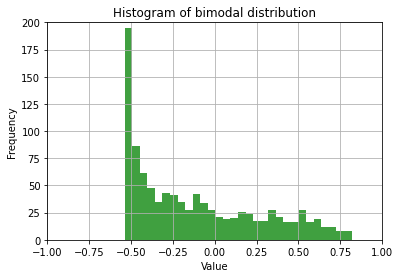

In [59]:
# the histogram of the data
plt.hist(samples, 30, facecolor='g', alpha=0.75)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of bimodal distribution')
plt.xlim(-1, 1)
plt.ylim(0, 200)
plt.grid(True)
plt.show()

In [10]:
samples = []
num_samples = 1000
w = [0.17114291798924963, 0.9779342589281095, 0.6282792870387003]
for i in range(num_samples):
    samples.append(gen_circuit(w))

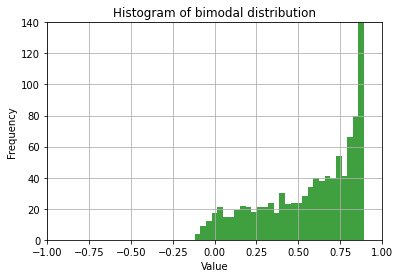

In [11]:
# the histogram of the data
plt.hist(samples, 30, facecolor='g', alpha=0.75)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of bimodal distribution')
plt.xlim(-1, 1)
plt.ylim(0, 140)
plt.grid(True)
plt.show()